In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
%matplotlib inline

In [2]:
demo = pd.read_csv("Data files/Demographics.csv")
demo.head()

,Postcode,0-9 years,10-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60-69 years,70-79 years,80-89 years,...,Other Religions,Secular Beliefs and Other Spiritual Beliefs and No Religious Affiliation,Inadequately described,Not stated,Never married,Widowed,Divorced,Separated,Married,Not applicable
0,800,424,230,1939,1691,819,752,457,126,33,...,49,2294,48,1183,3034,76,458,177,2182,536
1,810,4840,3746,5181,6091,4882,3798,2861,1408,434,...,365,10122,219,4098,10521,892,2073,811,12254,6752
2,812,2753,2541,2504,2911,2696,2664,1862,734,190,...,136,5667,114,2292,5744,489,1289,507,6777,4069
3,820,2104,1803,3723,3812,2845,2442,1718,695,249,...,150,6751,135,2561,7171,446,1458,457,6860,3051
4,822,4381,4454,4081,4109,3443,2831,1613,532,109,...,1108,4253,60,3660,8203,854,940,500,8394,6664


### Merging columns

In [3]:
#merging columns for simplicity

#Age group

demo['Kids and Teens']= demo['0-9 years'] + demo['10-19 years']
demo['Adults']= demo['20-29 years'] + demo['30-39 years'] + demo['40-49 years'] + demo['50-59 years'] 
demo['Seniors']= demo['60-69 years'] + demo['70-79 years'] + demo['80-89 years'] + demo['90-99 years'] + demo['100 years and over']

#Marital Status
demo['Single']= demo['Never married'] + demo['Widowed'] + demo['Divorced'] + demo ['Separated']

#Religious Affiliation 
demo['Not stated/described'] = demo['Inadequately described'] + demo['Not stated']



In [4]:
#dropping columns that have been merged

demo = demo.drop(['0-9 years','10-19 years','20-29 years','30-39 years','40-49 years','50-59 years','60-69 years','70-79 years','80-89 years','90-99 years','100 years and over','Never married','Widowed', 'Divorced', 'Separated', 'Inadequately described', 'Not stated'], axis = 1)


#changing column name

demo = demo.rename(columns={"Secular Beliefs and Other Spiritual Beliefs and No Religious Affiliation":"No Religious Affiliation"})
demo.head()



,Postcode,Male,Female,Buddhism,Christianity,Hinduism,Islam,Judaism,Other Religions,No Religious Affiliation,Married,Not applicable,Kids and Teens,Adults,Seniors,Single,Not stated/described
0,800,3629,2835,274,2226,295,94,7,49,2294,2182,536,654,5201,620,3745,1231
1,810,16776,16530,1142,15094,1386,839,33,365,10122,12254,6752,8586,19952,4770,14297,4317
2,812,9442,9429,692,9404,247,318,9,136,5667,6777,4069,5294,10775,2800,8029,2406
3,820,10205,9249,519,8636,426,260,12,150,6751,6860,3051,3907,12822,2719,9532,2696
4,822,13146,12414,216,16234,18,16,4,1108,4253,8394,6664,8835,14464,2258,10497,3720


In [5]:
# Reordering the columns

demo = demo [['Postcode','Kids and Teens', 'Adults', 'Seniors', 'Male', 'Female', 'Buddhism', 'Christianity', 'Hinduism', 'Islam', 'Judaism', 'Other Religions', 'No Religious Affiliation', 'Not stated/described', 'Single', 'Married', 'Not applicable']]
demo.head()



,Postcode,Kids and Teens,Adults,Seniors,Male,Female,Buddhism,Christianity,Hinduism,Islam,Judaism,Other Religions,No Religious Affiliation,Not stated/described,Single,Married,Not applicable
0,800,654,5201,620,3629,2835,274,2226,295,94,7,49,2294,1231,3745,2182,536
1,810,8586,19952,4770,16776,16530,1142,15094,1386,839,33,365,10122,4317,14297,12254,6752
2,812,5294,10775,2800,9442,9429,692,9404,247,318,9,136,5667,2406,8029,6777,4069
3,820,3907,12822,2719,10205,9249,519,8636,426,260,12,150,6751,2696,9532,6860,3051
4,822,8835,14464,2258,13146,12414,216,16234,18,16,4,1108,4253,3720,10497,8394,6664


In [6]:
demo.shape

(2472, 17)

In [7]:
demo.info

<bound method DataFrame.info of       Postcode  Kids and Teens  Adults  Seniors   Male  Female  Buddhism  \
0          800             654    5201      620   3629    2835       274   
1          810            8586   19952     4770  16776   16530      1142   
2          812            5294   10775     2800   9442    9429       692   
3          820            3907   12822     2719  10205    9249       519   
4          822            8835   14464     2258  13146   12414       216   
...        ...             ...     ...      ...    ...     ...       ...   
2467      7331             423     902      463    924     866         6   
2468      7467             140     382      176    356     349         0   
2469      7468             166     416      177    405     362         4   
2470      7469             173     401      138    377     335         0   
2471      7470             173     401      138    377     335         0   

      Christianity  Hinduism  Islam  Judaism  Other Rel

In [8]:
demo.describe()

,Postcode,Kids and Teens,Adults,Seniors,Male,Female,Buddhism,Christianity,Hinduism,Islam,Judaism,Other Religions,No Religious Affiliation,Not stated/described,Single,Married,Not applicable
count,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000
mean,4094.410599,2306.949434,5033.539644,1993.224919,4602.199434,4731.743528,270.192961,4554.999191,498.359223,240.868123,47.985032,81.833738,2553.961165,1072.875000,3931.119741,3646.538430,1738.259709
std,1496.667668,3362.469271,6925.726768,2598.905790,6173.387773,6415.891468,718.837013,6853.428035,1525.616565,995.173722,284.371032,266.569957,3640.891934,1473.509131,5285.780468,4974.047746,2570.103033
min,800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2839.750000,209.000000,443.000000,230.750000,462.750000,427.500000,6.000000,300.000000,0.000000,0.000000,0.000000,0.000000,157.000000,124.750000,347.250000,357.000000,152.000000
50%,3869.500000,908.500000,1913.000000,977.000000,1971.000000,1947.000000,46.500000,1554.500000,18.000000,7.000000,0.000000,11.000000,812.000000,480.500000,1566.500000,1577.500000,684.000000
75%,5165.250000,3091.500000,7113.000000,2876.250000,6671.500000,6953.000000,267.250000,6519.500000,260.500000,100.250000,14.000000,67.000000,3822.500000,1465.500000,5767.500000,5124.000000,2294.750000
max,7470.000000,30230.000000,57777.000000,25002.000000,52026.000000,55742.000000,20631.000000,69539.000000,18314.000000,16053.000000,6319.000000,5271.000000,27107.000000,14788.000000,46068.000000,42099.000000,24484.000000


In [9]:
demo.columns

Index(['Postcode', 'Kids and Teens', 'Adults', 'Seniors', 'Male', 'Female',
       'Buddhism', 'Christianity', 'Hinduism', 'Islam', 'Judaism',
       'Other Religions', 'No Religious Affiliation', 'Not stated/described',
       'Single', 'Married', 'Not applicable'],
      dtype='object')

<AxesSubplot:xlabel='Female'>

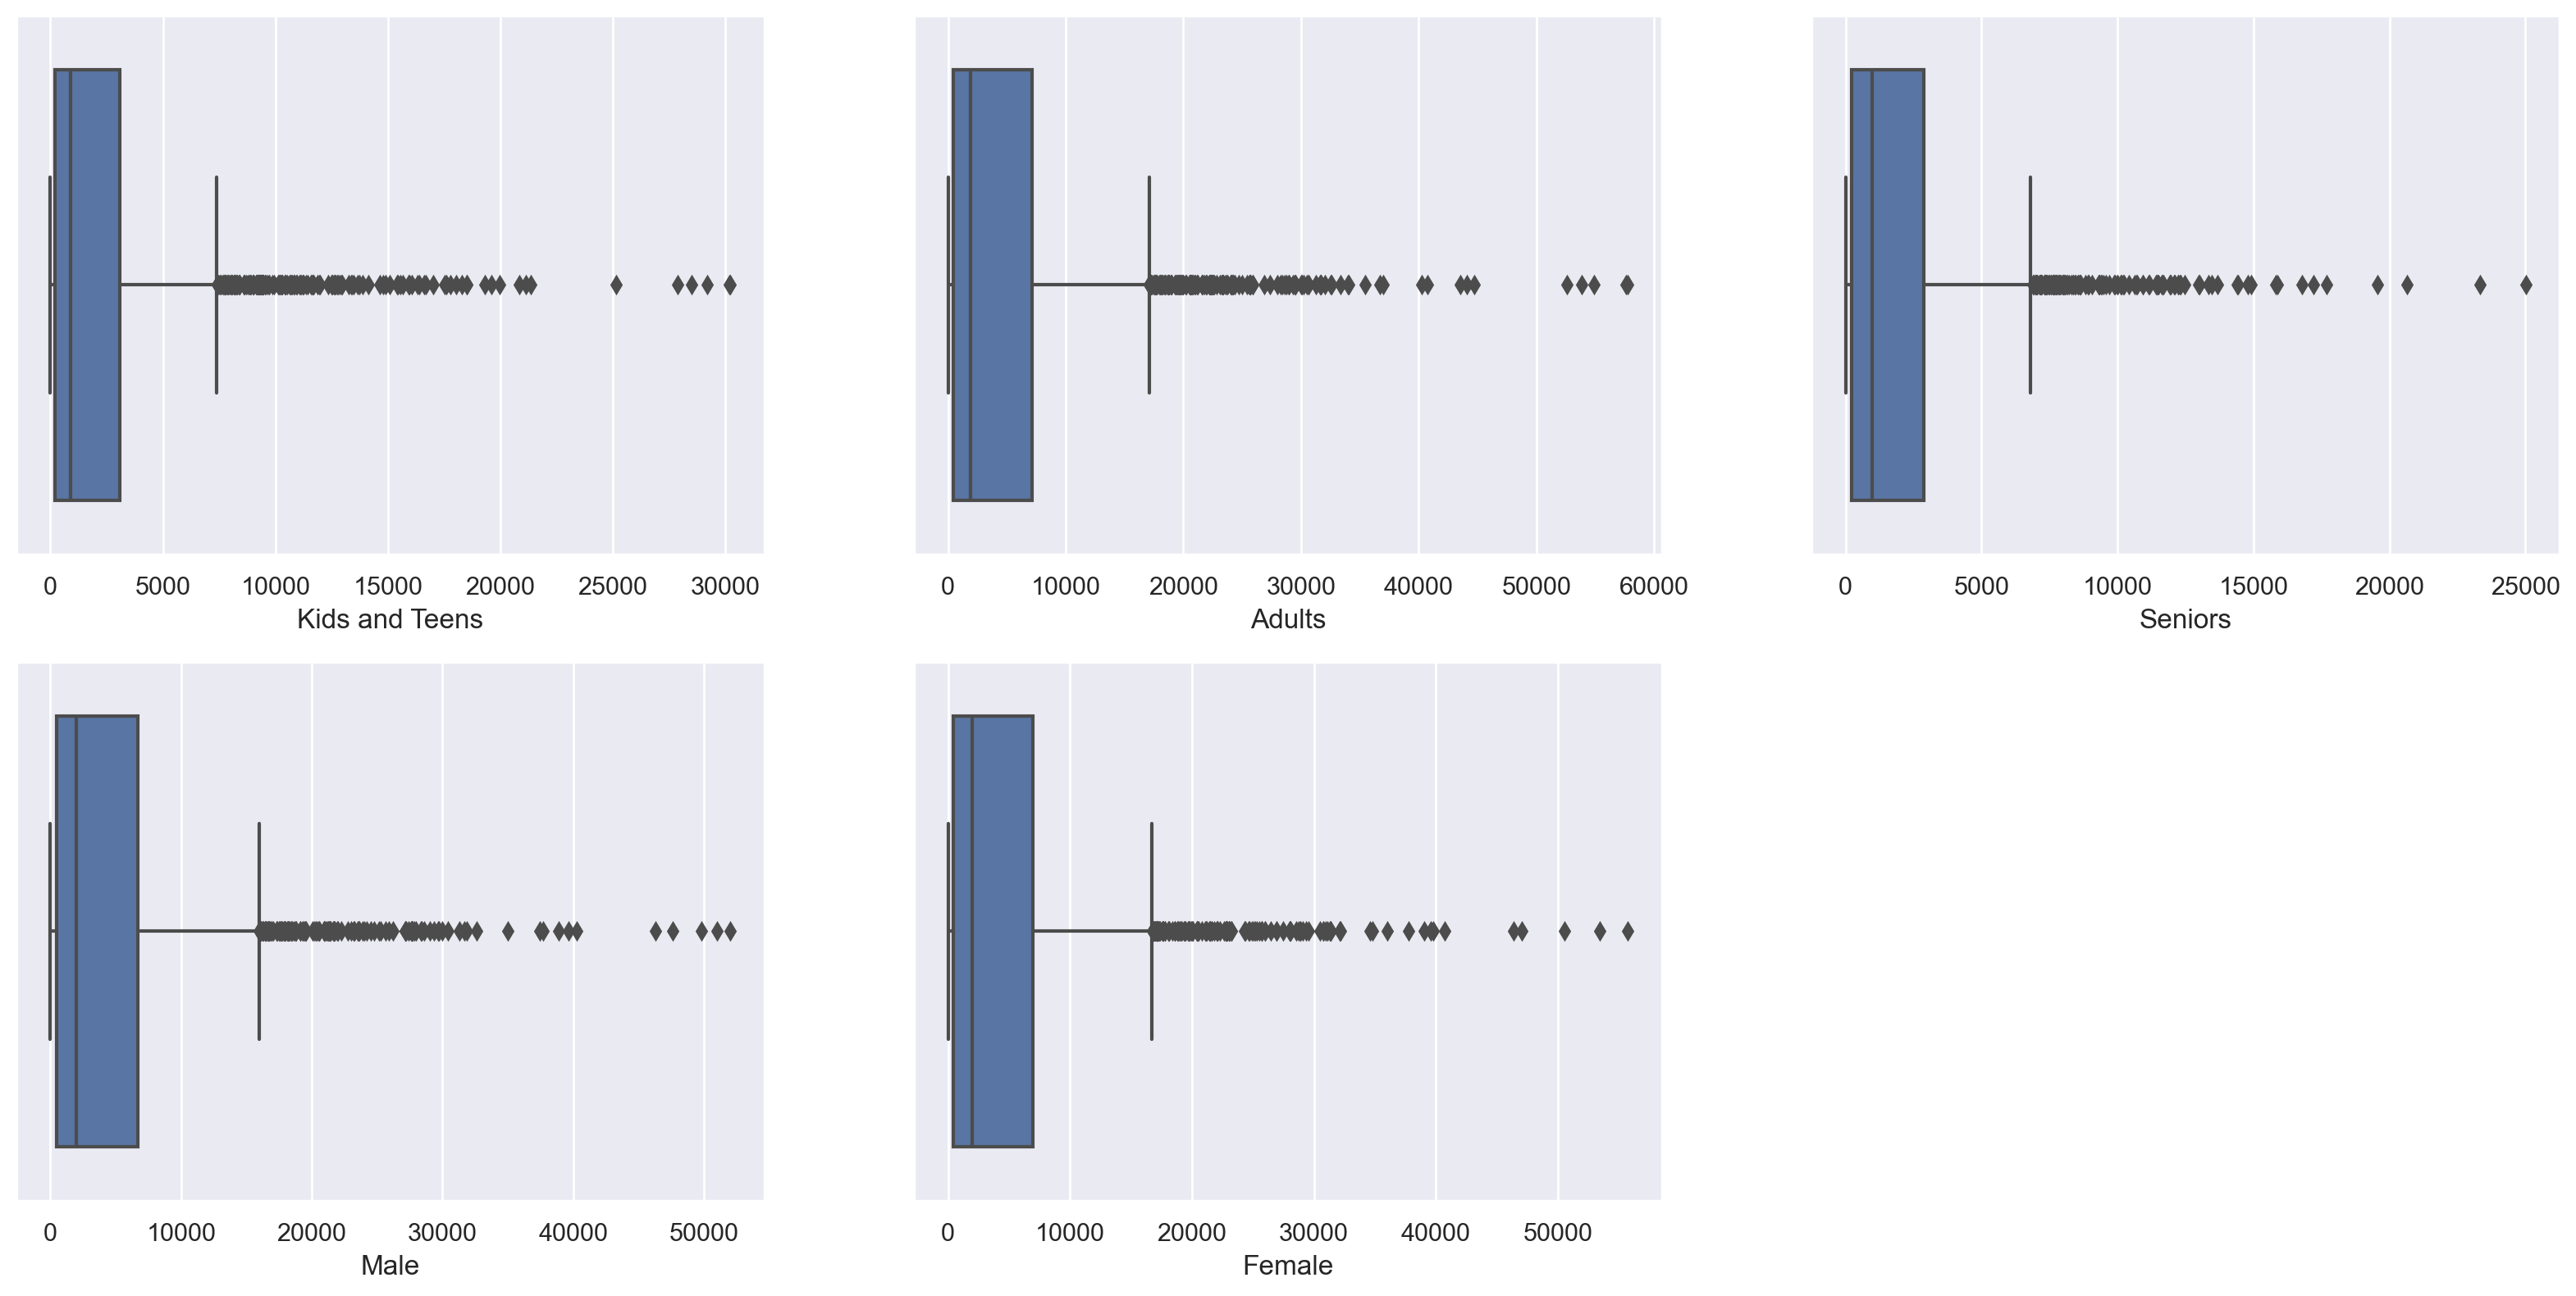

In [10]:
# checking for outliers using box-plots

plt.figure(figsize=(20,20), dpi=200)

plt.subplot(4,3,1)
sns.boxplot(x = 'Kids and Teens', data = demo)

plt.subplot(4,3,2)
sns.boxplot(x = 'Adults', data = demo)

plt.subplot(4,3,3)
sns.boxplot(x = 'Seniors', data = demo)

plt.subplot(4,3,4)
sns.boxplot(x = 'Male', data = demo)

plt.subplot(4,3,5)
sns.boxplot(x = 'Female', data = demo)


<AxesSubplot:xlabel='Not applicable'>

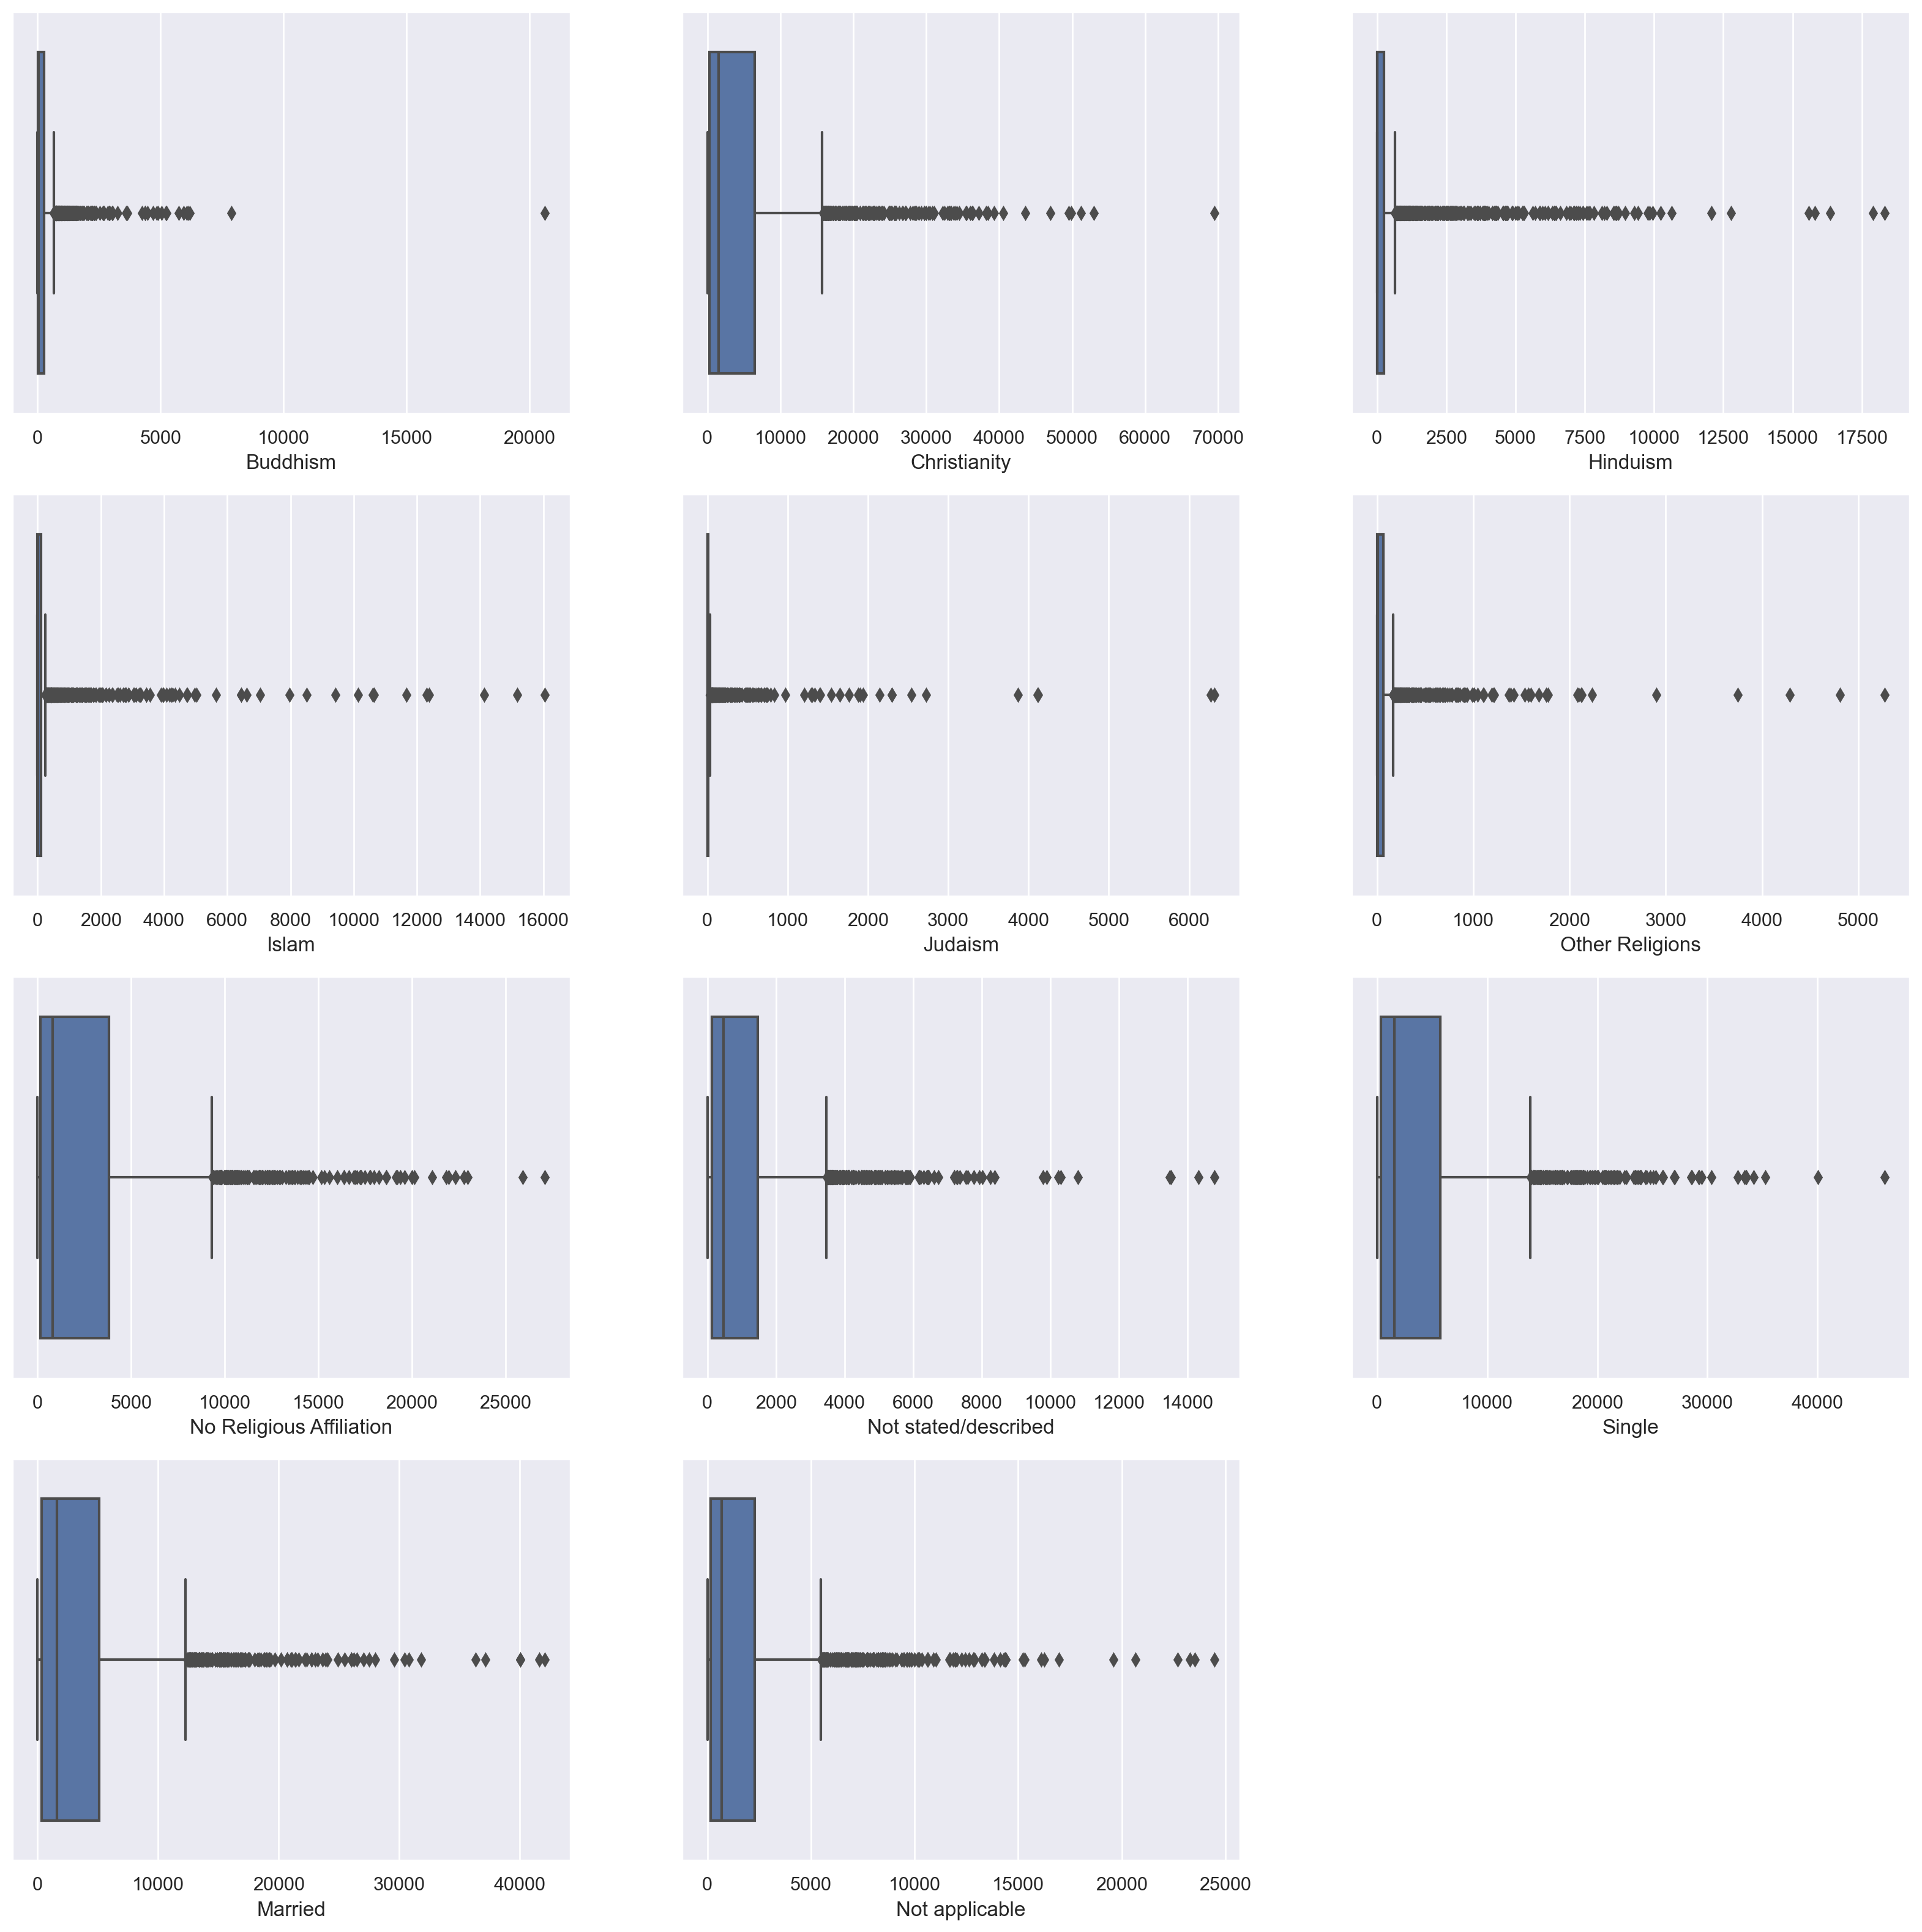

In [11]:

plt.figure(figsize=(20,20), dpi=200)

plt.subplot(4,3,1)
sns.boxplot(x = 'Buddhism', data = demo)

plt.subplot(4,3,2)
sns.boxplot(x = 'Christianity', data = demo)

plt.subplot(4,3,3)
sns.boxplot(x = 'Hinduism', data = demo)

plt.subplot(4,3,4)
sns.boxplot(x = 'Islam', data = demo)

plt.subplot(4,3,5)
sns.boxplot(x = 'Judaism', data = demo)

plt.subplot(4,3,6)
sns.boxplot(x = 'Other Religions', data = demo)

plt.subplot(4,3,7)
sns.boxplot(x = 'No Religious Affiliation', data = demo)

plt.subplot(4,3,8)
sns.boxplot(x = 'Not stated/described', data = demo)

plt.subplot(4,3,9)
sns.boxplot(x = 'Single', data = demo)

plt.subplot(4,3,10)
sns.boxplot(x = 'Married', data = demo)

plt.subplot(4,3,11)
sns.boxplot(x = 'Not applicable', data = demo)




### Removing outliers

In [12]:
# checking for outliers using the Z-score

from scipy import stats

z = np.abs(stats.zscore(demo[['Kids and Teens', 'Adults', 'Seniors', 'Male', 'Female',
       'Buddhism', 'Christianity', 'Hinduism', 'Islam', 'Judaism',
       'Other Religions', 'No Religious Affiliation', 'Not stated/described',
       'Single', 'Married', 'Not applicable']]))
print(z)

print("\n")
print("*******************************************************************************")
print("\n")

# threshold = 3  # selecting 3 as the threshold to identify outliers
print('Below are the outlier points along with the respective column numbers in the second array')
print("\n")
print(np.where(z > 3))

[[0.49168743 0.02418436 0.52849271 ... 0.03521853 0.29449551 0.46788123]
 [1.86777052 2.15450006 1.06865624 ... 1.96148471 1.73082438 1.9511882 ]
 [0.88853003 0.82917248 0.31049156 ... 0.77542179 0.62948631 0.90704996]
 ...
 [0.63684823 0.66685765 0.69898355 ... 0.67707006 0.6811804  0.61848931]
 [0.63476601 0.66902393 0.7139929  ... 0.68236836 0.68560425 0.62121349]
 [0.63476601 0.66902393 0.7139929  ... 0.68236836 0.68560425 0.62121349]]


*******************************************************************************


Below are the outlier points along with the respective column numbers in the second array


(array([   4,   29,   34,   43,   44,   47,   50,   51,   52,   56,   88,
        147,  147,  148,  150,  151,  151,  151,  151,  151,  151,  151,
        151,  151,  151,  151,  151,  151,  153,  154,  154,  154,  154,
        154,  154,  154,  154,  154,  154,  154,  154,  155,  155,  158,
        158,  158,  158,  158,  158,  158,  158,  159,  160,  160,  160,
        160,  

In [13]:
# Removing the outliers
demo_outliers_removed = demo[(z<3).all(axis=1)]

In [14]:
demo_outliers_removed.head()

,Postcode,Kids and Teens,Adults,Seniors,Male,Female,Buddhism,Christianity,Hinduism,Islam,Judaism,Other Religions,No Religious Affiliation,Not stated/described,Single,Married,Not applicable
0,800,654,5201,620,3629,2835,274,2226,295,94,7,49,2294,1231,3745,2182,536
1,810,8586,19952,4770,16776,16530,1142,15094,1386,839,33,365,10122,4317,14297,12254,6752
2,812,5294,10775,2800,9442,9429,692,9404,247,318,9,136,5667,2406,8029,6777,4069
3,820,3907,12822,2719,10205,9249,519,8636,426,260,12,150,6751,2696,9532,6860,3051
5,828,395,621,199,627,572,26,494,21,13,0,20,390,244,568,389,243


In [15]:
print('Shape of dataframe before outlier removal: ' + str(demo.shape))
print("\n")
print('Shape of dataframe after outlier removal: ' + str(demo_outliers_removed.shape))

Shape of dataframe before outlier removal: (2472, 17)


Shape of dataframe after outlier removal: (2262, 17)


In [16]:
X_demo = demo_outliers_removed.drop('Postcode',axis =1)  
y_demo = demo_outliers_removed['Postcode']

In [17]:
X_demo.shape

(2262, 16)

In [18]:
y_demo.shape

(2262,)

## Principal Component Analysis: Demographics 

In [19]:
X_demo.head()

,Kids and Teens,Adults,Seniors,Male,Female,Buddhism,Christianity,Hinduism,Islam,Judaism,Other Religions,No Religious Affiliation,Not stated/described,Single,Married,Not applicable
0,654,5201,620,3629,2835,274,2226,295,94,7,49,2294,1231,3745,2182,536
1,8586,19952,4770,16776,16530,1142,15094,1386,839,33,365,10122,4317,14297,12254,6752
2,5294,10775,2800,9442,9429,692,9404,247,318,9,136,5667,2406,8029,6777,4069
3,3907,12822,2719,10205,9249,519,8636,426,260,12,150,6751,2696,9532,6860,3051
5,395,621,199,627,572,26,494,21,13,0,20,390,244,568,389,243


In [20]:
y_demo.head()

0    800
1    810
2    812
3    820
5    828
Name: Postcode, dtype: int64

### Standardizing the dataset

In [21]:
scaler = StandardScaler()
X_scaled_demo = scaler.fit_transform(X_demo)

In [22]:
X_scaled_demo[:5,:5]

array([[-0.48672989,  0.313672  , -0.50952578,  0.045737  , -0.16306433],
       [ 3.25314035,  3.49081347,  1.7805964 ,  3.26704043,  3.03985576],
       [ 1.70099048,  1.51422698,  0.69347816,  1.47004953,  1.37910837],
       [ 1.04703182,  1.95511971,  0.64877939,  1.65700127,  1.33701084],
       [-0.60884617, -0.67279048, -0.74184901, -0.68981887, -0.69232377]])

In [23]:
X_demo.columns

Index(['Kids and Teens', 'Adults', 'Seniors', 'Male', 'Female', 'Buddhism',
       'Christianity', 'Hinduism', 'Islam', 'Judaism', 'Other Religions',
       'No Religious Affiliation', 'Not stated/described', 'Single', 'Married',
       'Not applicable'],
      dtype='object')

In [24]:
X_scaled_demo_df = pd.DataFrame(X_scaled_demo, columns = X_demo.columns)
X_scaled_demo_df.head()

,Kids and Teens,Adults,Seniors,Male,Female,Buddhism,Christianity,Hinduism,Islam,Judaism,Other Religions,No Religious Affiliation,Not stated/described,Single,Married,Not applicable
0,-0.486730,0.313672,-0.509526,0.045737,-0.163064,0.409894,-0.285082,0.065761,-0.059353,-0.183877,0.027804,0.080980,0.532917,0.217974,-0.164876,-0.455158
1,3.253140,3.490813,1.780596,3.267040,3.039856,3.466641,2.512059,1.656439,2.194682,0.197346,3.492047,2.957212,4.063565,3.131532,2.870714,3.415190
2,1.700990,1.514227,0.693478,1.470050,1.379108,1.881922,1.275213,-0.004223,0.618370,-0.154552,0.981568,1.320317,1.877217,1.400848,1.220007,1.744640
3,1.047032,1.955120,0.648779,1.657001,1.337011,1.272685,1.108271,0.256759,0.442889,-0.110564,1.135047,1.718610,2.209002,1.815847,1.245022,1.110789
4,-0.608846,-0.672790,-0.741849,-0.689819,-0.692324,-0.463462,-0.661570,-0.333730,-0.304422,-0.286513,-0.290117,-0.618604,-0.596296,-0.659240,-0.705266,-0.637592


###  Correlation matrix: Variables


Correlation matrix of the scaled demographic dataset

<AxesSubplot:>

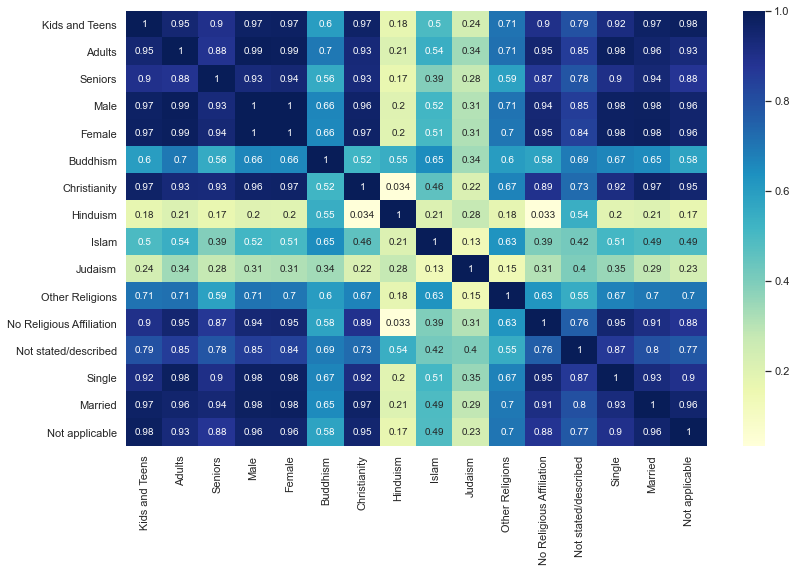

In [25]:
plt.figure(figsize = (13,8))       
sns.heatmap(X_scaled_demo_df.corr(),annot = True, cmap="YlGnBu")

## PCA

Performing PCA on the standardized demographica dataset

In [26]:
pca_demo = PCA(random_state = 42)
pca_demo.fit(X_scaled_demo)

PCA(random_state=42)

In [27]:
pca_demo.components_[0]

array([0.28378479, 0.2894977 , 0.27049263, 0.29156627, 0.29145443,
       0.21045285, 0.2774513 , 0.07599473, 0.16639739, 0.10006251,
       0.21832715, 0.27241884, 0.25353815, 0.28524044, 0.28683001,
       0.27927601])

In [28]:
# finding the total variance explained ratio

pca_demo.explained_variance_ratio_

array([7.26253070e-01, 9.69664453e-02, 6.49552767e-02, 4.42792813e-02,
       2.12212941e-02, 1.65855659e-02, 1.21995382e-02, 8.33777856e-03,
       4.13927826e-03, 2.60435419e-03, 1.46622596e-03, 7.43682400e-04,
       1.68151700e-04, 7.53171054e-05, 4.69363648e-06, 4.65556186e-08])

In [29]:
# finding the cummulative total variance explained ratio

var_cumu_demo = np.cumsum(pca_demo.explained_variance_ratio_)
var_cumu_demo

array([0.72625307, 0.82321952, 0.88817479, 0.93245407, 0.95367537,
       0.97026093, 0.98246047, 0.99079825, 0.99493753, 0.99754188,
       0.99900811, 0.99975179, 0.99991994, 0.99999526, 0.99999995,
       1.        ])

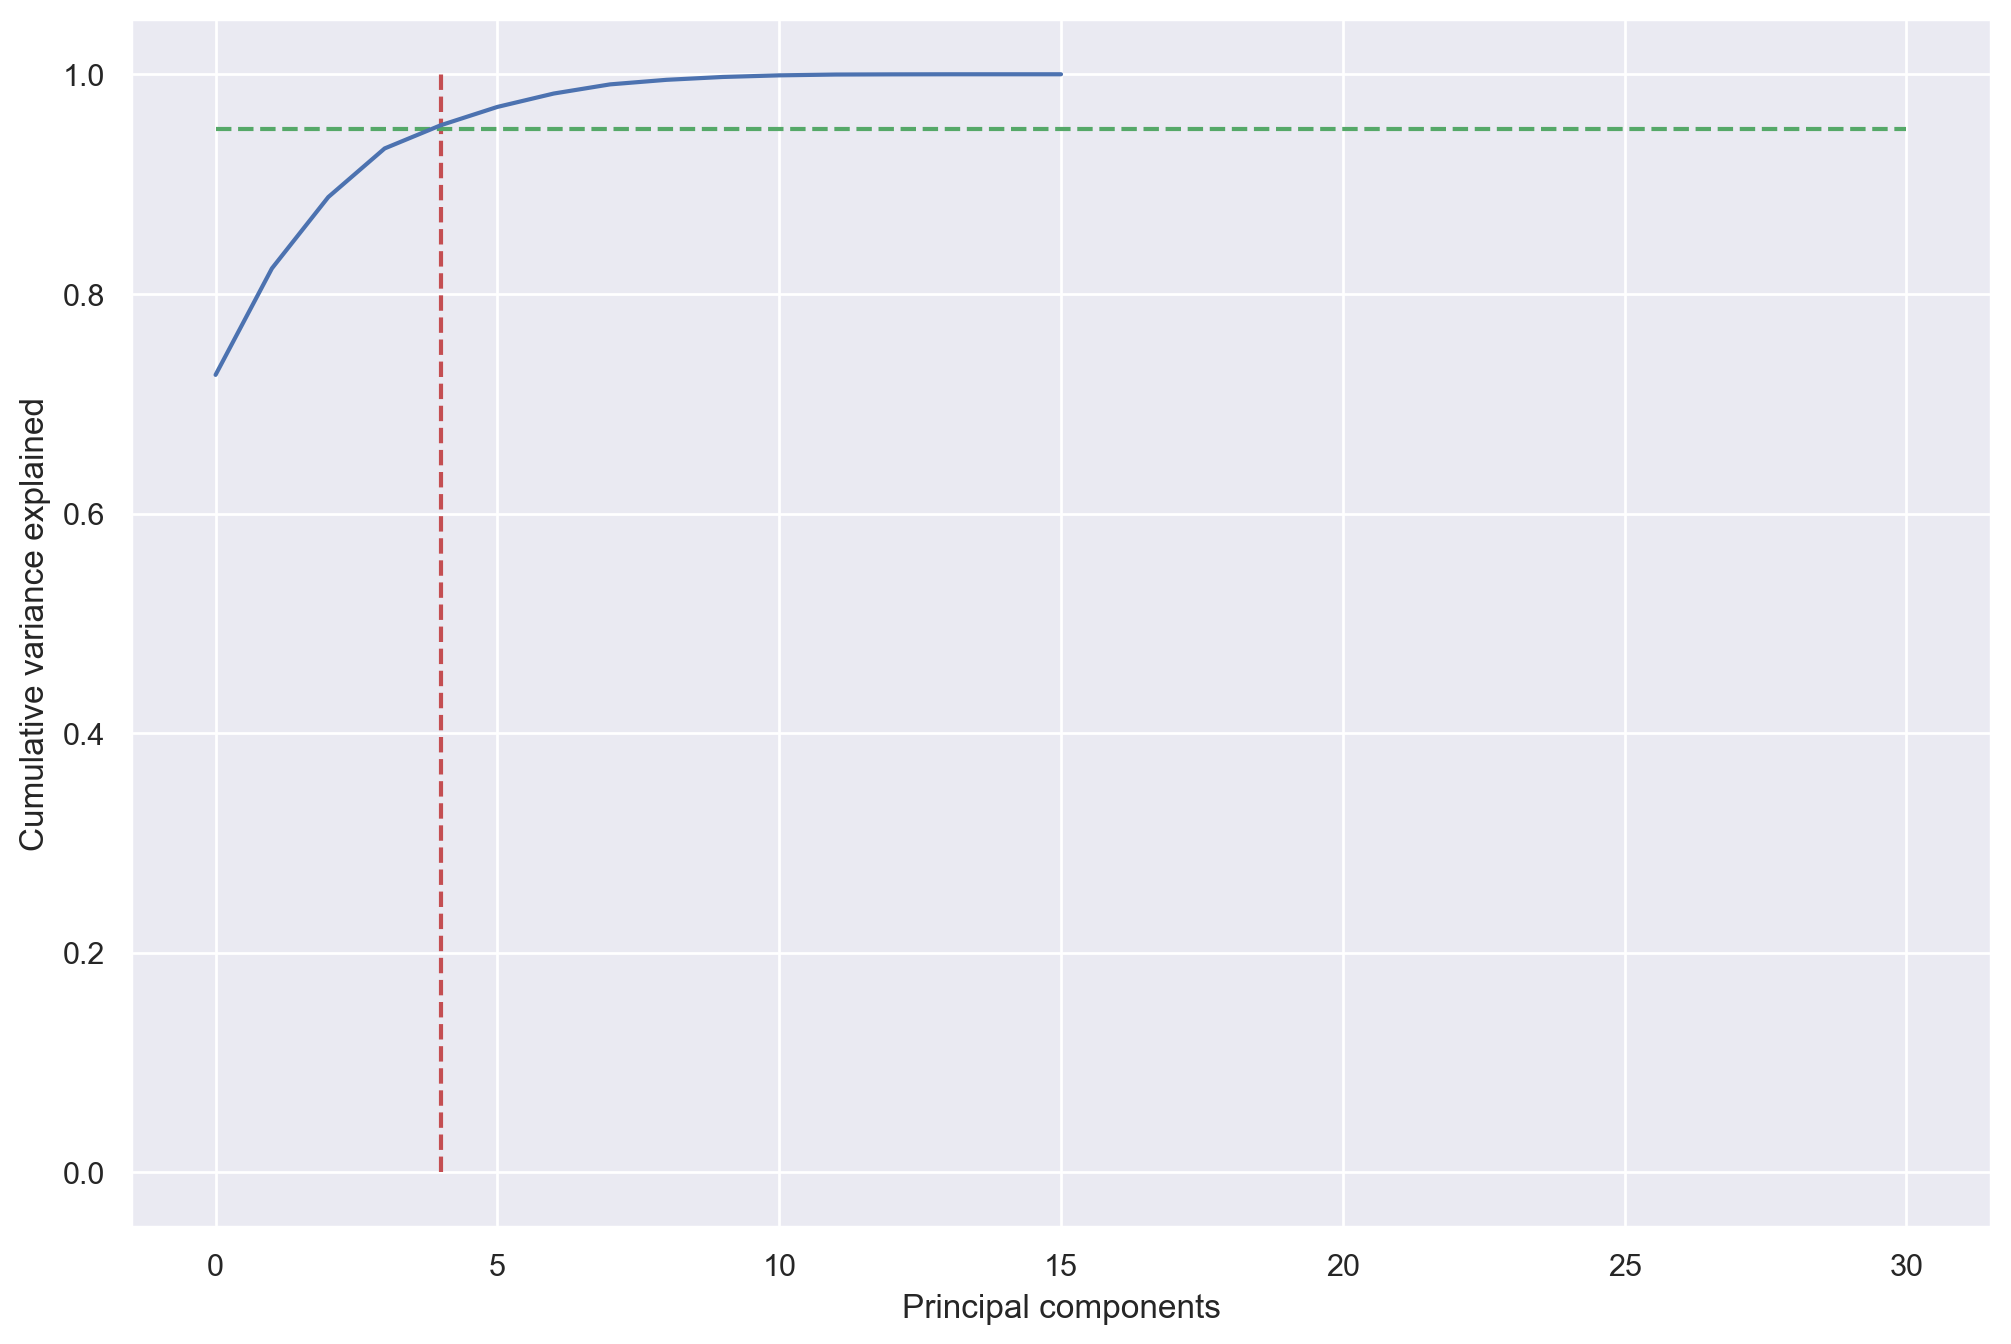

In [30]:
# plotting the cummulative total variance explained ratio
fig = plt.figure(figsize=[12,8],dpi=200)
plt.vlines(x=4, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu_demo)
plt.xlabel("Principal components")
plt.ylabel("Cumulative variance explained")
plt.show()

**The PCA vs. Cummulative Variance Explained graph suggests that 4 PCs need to be taken in consideration**

In [31]:
pca_demo_final = IncrementalPCA(n_components=4)

In [32]:
X_pca_demo_final = pca_demo_final.fit_transform(X_scaled_demo)

In [33]:
print(X_demo.shape)
print(X_pca_demo_final.shape)

(2262, 16)
(2262, 4)


### Correlation matrix: PCs

Heatmap of the correlation matrix of the 4 PCs.

In [34]:
corrmat_demo = np.corrcoef(X_pca_demo_final.transpose())

In [35]:
corrmat_demo.shape

(4, 4)

<AxesSubplot:>

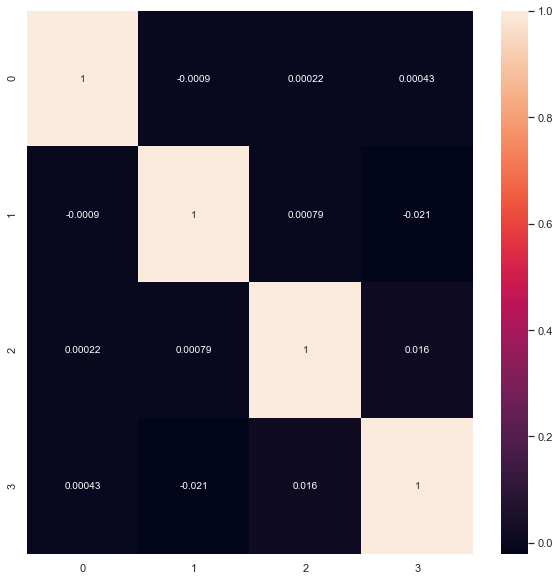

In [36]:
# Plotting the heatmap of the corr matrix
plt.figure(figsize=[10,10])
sns.heatmap(corrmat_demo, annot=True)

# Clustering : K means & Heirarchical

## K-means Clustering 

In [37]:
# k-means with some arbitrary k (number of clusters)
kmeans_demo = KMeans(n_clusters=5, max_iter=1000)
kmeans_demo.fit(X_pca_demo_final)

KMeans(max_iter=1000, n_clusters=5)

In [38]:
kmeans_demo.labels_

array([1, 4, 2, ..., 1, 1, 1], dtype=int32)

Finding the optimal number of clusters

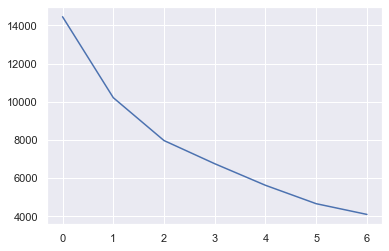

In [39]:
# elbow-curve/SSD
ssd_demo = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans_demo = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans_demo.fit(X_pca_demo_final)
    
    ssd_demo.append(kmeans_demo.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd_demo)

**From the elbow method, as seen from the above plot, we can csay that k = 4 clusters seems to be a good choice**

### Silhouette Analysis

We shall now be conducting silhouette analysis to study the seperation distance between the clusters we've chosen.

In [40]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans_demo = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans_demo.fit(X_pca_demo_final)
    
    cluster_demo_labels = kmeans_demo.labels_
    
    # silhouette score
    silhouette_avg_demo = silhouette_score(X_pca_demo_final, cluster_demo_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg_demo))
    

For n_clusters=2, the silhouette score is 0.637323102925322
For n_clusters=3, the silhouette score is 0.5953894664663636
For n_clusters=4, the silhouette score is 0.6227948370932652
For n_clusters=5, the silhouette score is 0.6144724108977289
For n_clusters=6, the silhouette score is 0.6219239434803647
For n_clusters=7, the silhouette score is 0.5573689188310862
For n_clusters=8, the silhouette score is 0.5676484140985864


In [41]:
# final model with k=3
kmeans_demo= KMeans(n_clusters=4, max_iter=1000, random_state=42)
kmeans_demo.fit(X_pca_demo_final)

KMeans(max_iter=1000, n_clusters=4, random_state=42)

In [42]:
kmeans_demo.labels_

array([0, 1, 2, ..., 0, 0, 0], dtype=int32)

In [43]:
demo_outliers_removed['K-Means_Cluster_ID_Demo'] = kmeans_demo.labels_

<ipython-input-43-b6e5e988eec4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_outliers_removed['K-Means_Cluster_ID_Demo'] = kmeans_demo.labels_


In [44]:
demo_outliers_removed.head()

,Postcode,Kids and Teens,Adults,Seniors,Male,Female,Buddhism,Christianity,Hinduism,Islam,Judaism,Other Religions,No Religious Affiliation,Not stated/described,Single,Married,Not applicable,K-Means_Cluster_ID_Demo
0,800,654,5201,620,3629,2835,274,2226,295,94,7,49,2294,1231,3745,2182,536,0
1,810,8586,19952,4770,16776,16530,1142,15094,1386,839,33,365,10122,4317,14297,12254,6752,1
2,812,5294,10775,2800,9442,9429,692,9404,247,318,9,136,5667,2406,8029,6777,4069,2
3,820,3907,12822,2719,10205,9249,519,8636,426,260,12,150,6751,2696,9532,6860,3051,2
5,828,395,621,199,627,572,26,494,21,13,0,20,390,244,568,389,243,0


<AxesSubplot:xlabel='K-Means_Cluster_ID_Demo', ylabel='Female'>

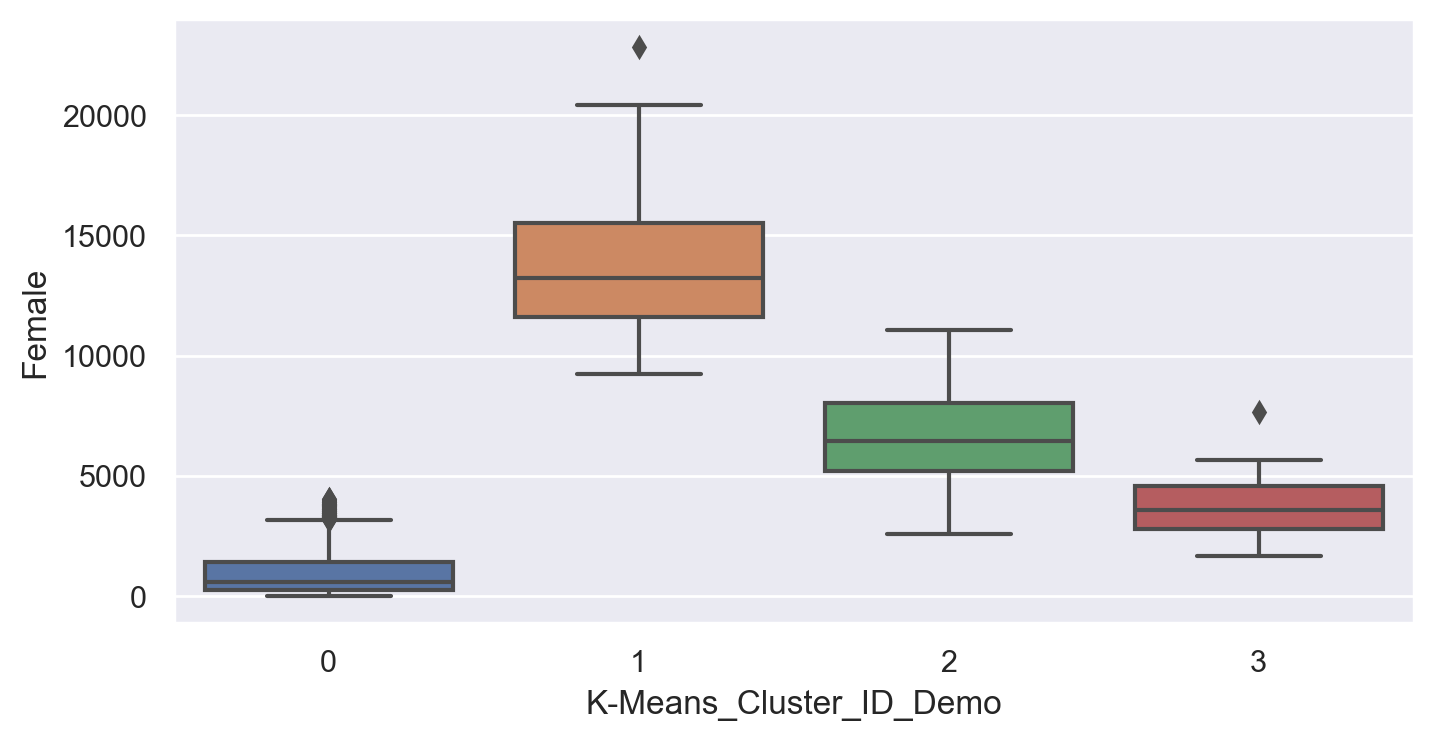

In [45]:
#plotting the clusters against Female
plt.figure(figsize=(8,4),dpi=200)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Female', data=demo_outliers_removed)

<AxesSubplot:xlabel='K-Means_Cluster_ID_Demo', ylabel='Single'>

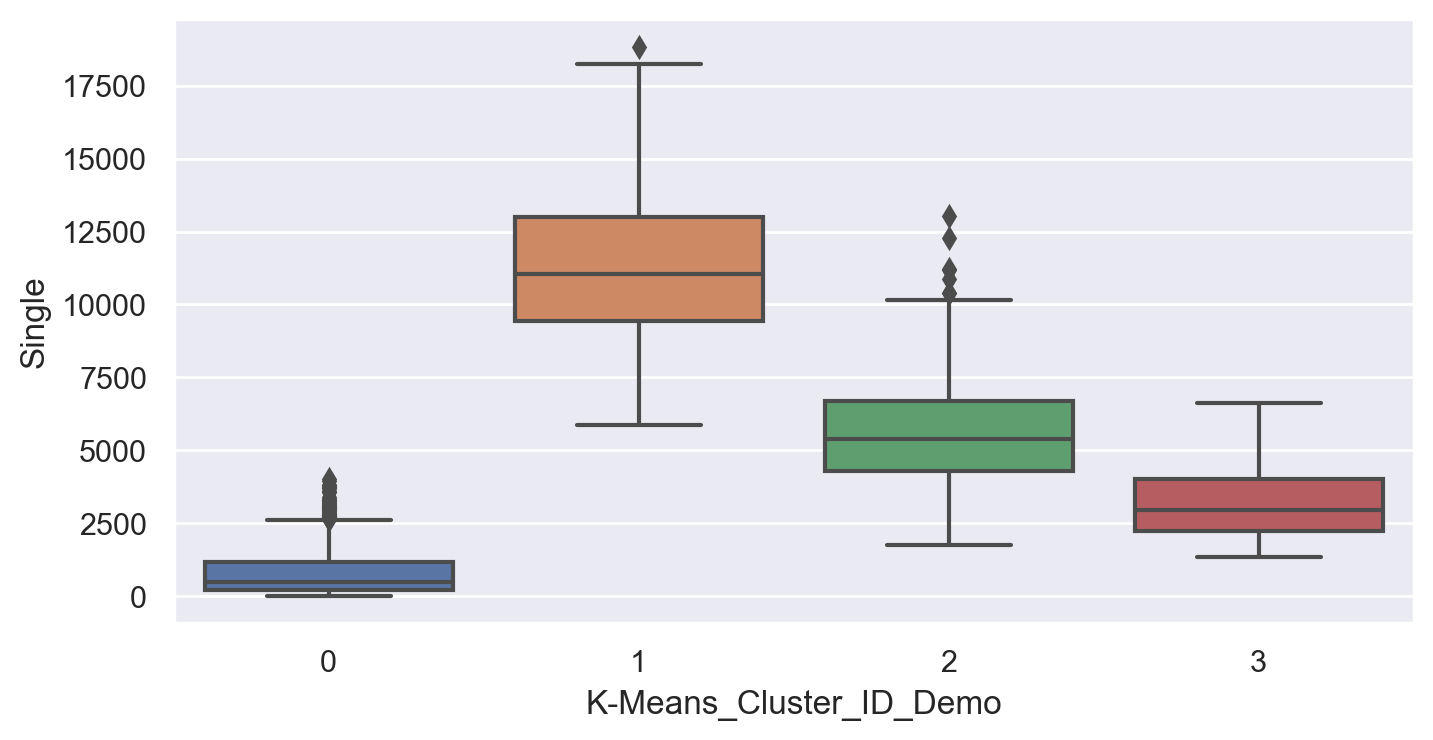

In [46]:
#plotting the clusters against Single
plt.figure(figsize=(8,4),dpi=200)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Single', data=demo_outliers_removed)

## Heirarchical Clustering

In [47]:
X_scaled_demo_df.head()

,Kids and Teens,Adults,Seniors,Male,Female,Buddhism,Christianity,Hinduism,Islam,Judaism,Other Religions,No Religious Affiliation,Not stated/described,Single,Married,Not applicable
0,-0.486730,0.313672,-0.509526,0.045737,-0.163064,0.409894,-0.285082,0.065761,-0.059353,-0.183877,0.027804,0.080980,0.532917,0.217974,-0.164876,-0.455158
1,3.253140,3.490813,1.780596,3.267040,3.039856,3.466641,2.512059,1.656439,2.194682,0.197346,3.492047,2.957212,4.063565,3.131532,2.870714,3.415190
2,1.700990,1.514227,0.693478,1.470050,1.379108,1.881922,1.275213,-0.004223,0.618370,-0.154552,0.981568,1.320317,1.877217,1.400848,1.220007,1.744640
3,1.047032,1.955120,0.648779,1.657001,1.337011,1.272685,1.108271,0.256759,0.442889,-0.110564,1.135047,1.718610,2.209002,1.815847,1.245022,1.110789
4,-0.608846,-0.672790,-0.741849,-0.689819,-0.692324,-0.463462,-0.661570,-0.333730,-0.304422,-0.286513,-0.290117,-0.618604,-0.596296,-0.659240,-0.705266,-0.637592


### Single Linkage

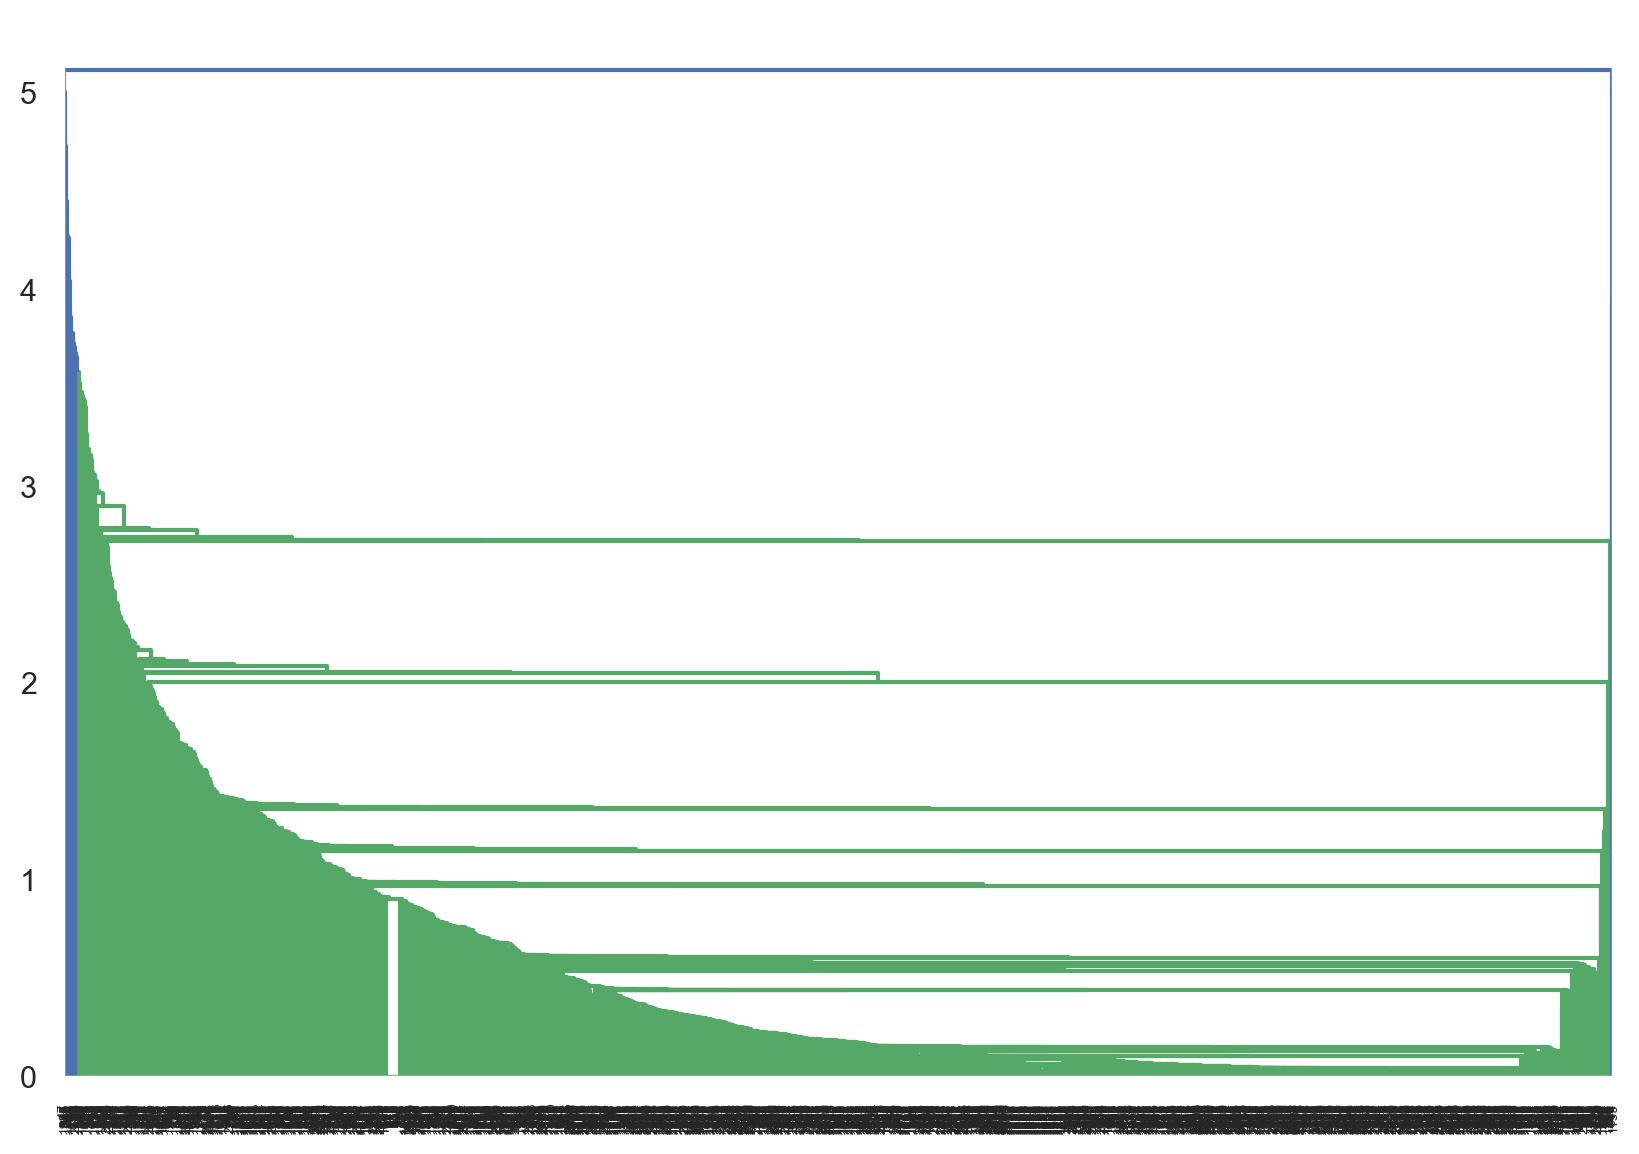

In [48]:
plt.figure(figsize=(10,7),dpi=200)
sl_merge_demo = linkage(X_scaled_demo_df, method="single", metric='euclidean')
dendrogram(sl_merge_demo)
plt.show()

### Complete Linkage

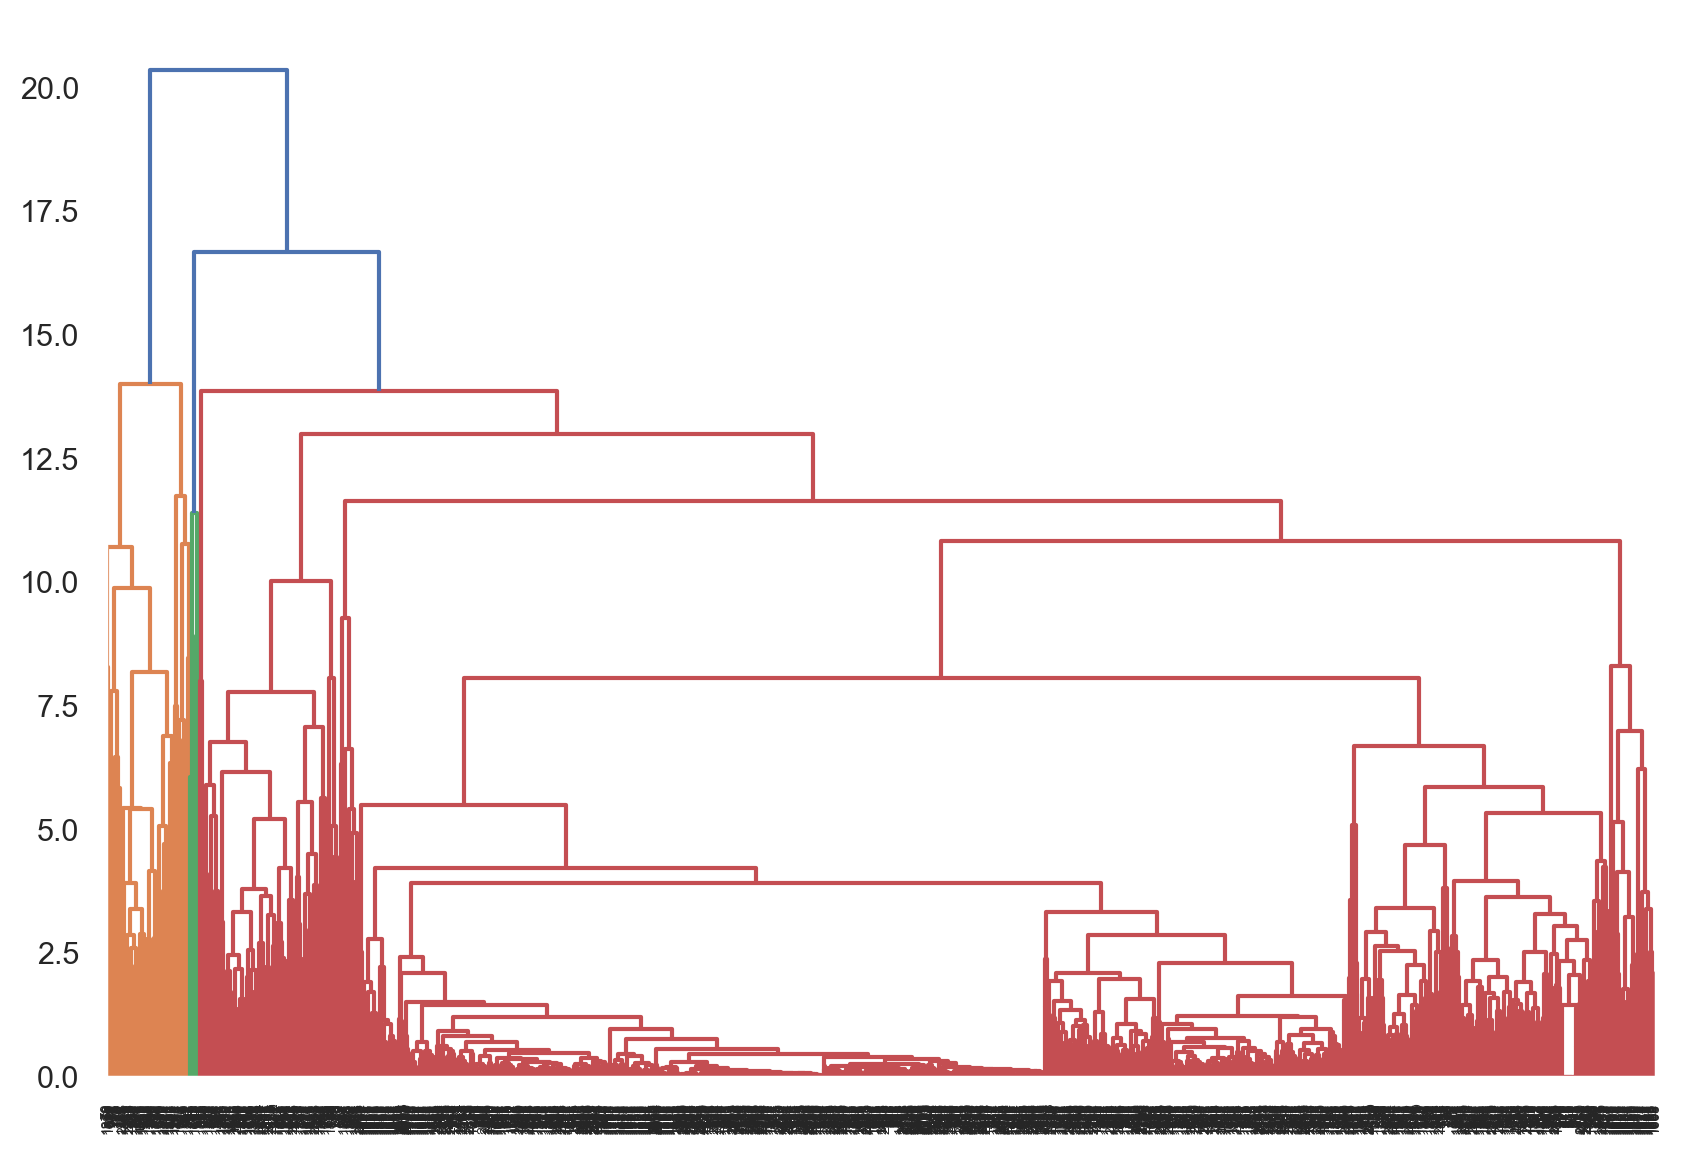

In [49]:

plt.figure(figsize=(10,7),dpi=200)
cl_merge_demo = linkage(X_scaled_demo_df, method="complete", metric='euclidean')
dendrogram(cl_merge_demo)
plt.show()

### Ward Linkage 

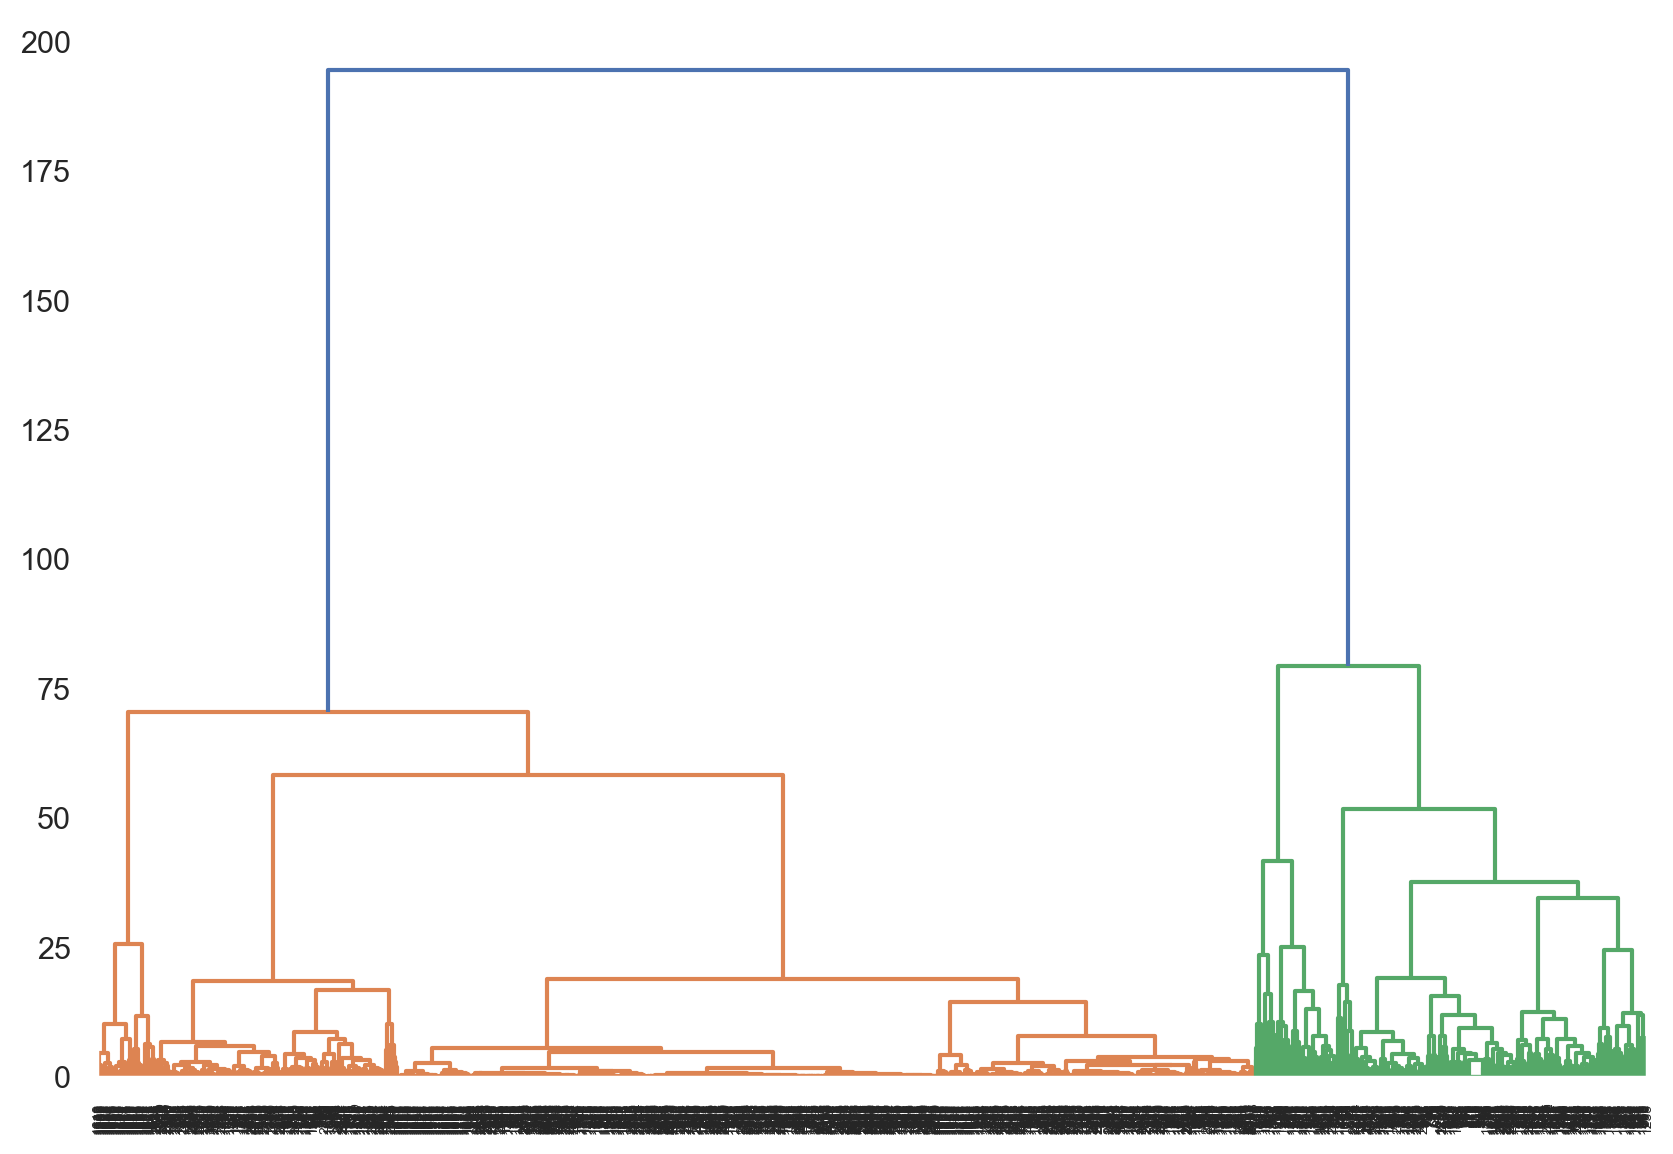

In [50]:
plt.figure(figsize=(10,7),dpi=200)
w_merge_demo = linkage(X_scaled_demo_df, method="ward", metric='euclidean')
dendrogram(w_merge_demo)
plt.show()

In [51]:
# 4 clusters using single linkge
sl_cluster_labels_demo = cut_tree(sl_merge_demo, n_clusters=4).reshape(-1, )
sl_cluster_labels_demo

array([0, 0, 0, ..., 0, 0, 0])

In [52]:
# 4 clusters using complete linkge
cl_cluster_labels_demo = cut_tree(cl_merge_demo, n_clusters=4).reshape(-1, )
cl_cluster_labels_demo

array([0, 1, 0, ..., 0, 0, 0])

In [53]:
# 4 clusters using ward linkge
w_cluster_labels_demo = cut_tree(w_merge_demo, n_clusters=4).reshape(-1, )
w_cluster_labels_demo

array([0, 1, 2, ..., 0, 0, 0])

**We go for ward linkage as single and complete linkage don't perform well in generating the clusters**

In [54]:
# adding the heirarchical cluster label to our dataset
demo_outliers_removed["Hier_Cluster_labels_demo"] = w_cluster_labels_demo

<ipython-input-54-52cdeecffdcc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_outliers_removed["Hier_Cluster_labels_demo"] = w_cluster_labels_demo


In [55]:
demo_outliers_removed.head()

,Postcode,Kids and Teens,Adults,Seniors,Male,Female,Buddhism,Christianity,Hinduism,Islam,Judaism,Other Religions,No Religious Affiliation,Not stated/described,Single,Married,Not applicable,K-Means_Cluster_ID_Demo,Hier_Cluster_labels_demo
0,800,654,5201,620,3629,2835,274,2226,295,94,7,49,2294,1231,3745,2182,536,0,0
1,810,8586,19952,4770,16776,16530,1142,15094,1386,839,33,365,10122,4317,14297,12254,6752,1,1
2,812,5294,10775,2800,9442,9429,692,9404,247,318,9,136,5667,2406,8029,6777,4069,2,2
3,820,3907,12822,2719,10205,9249,519,8636,426,260,12,150,6751,2696,9532,6860,3051,2,2
5,828,395,621,199,627,572,26,494,21,13,0,20,390,244,568,389,243,0,0


<AxesSubplot:xlabel='Hier_Cluster_labels_demo', ylabel='Female'>

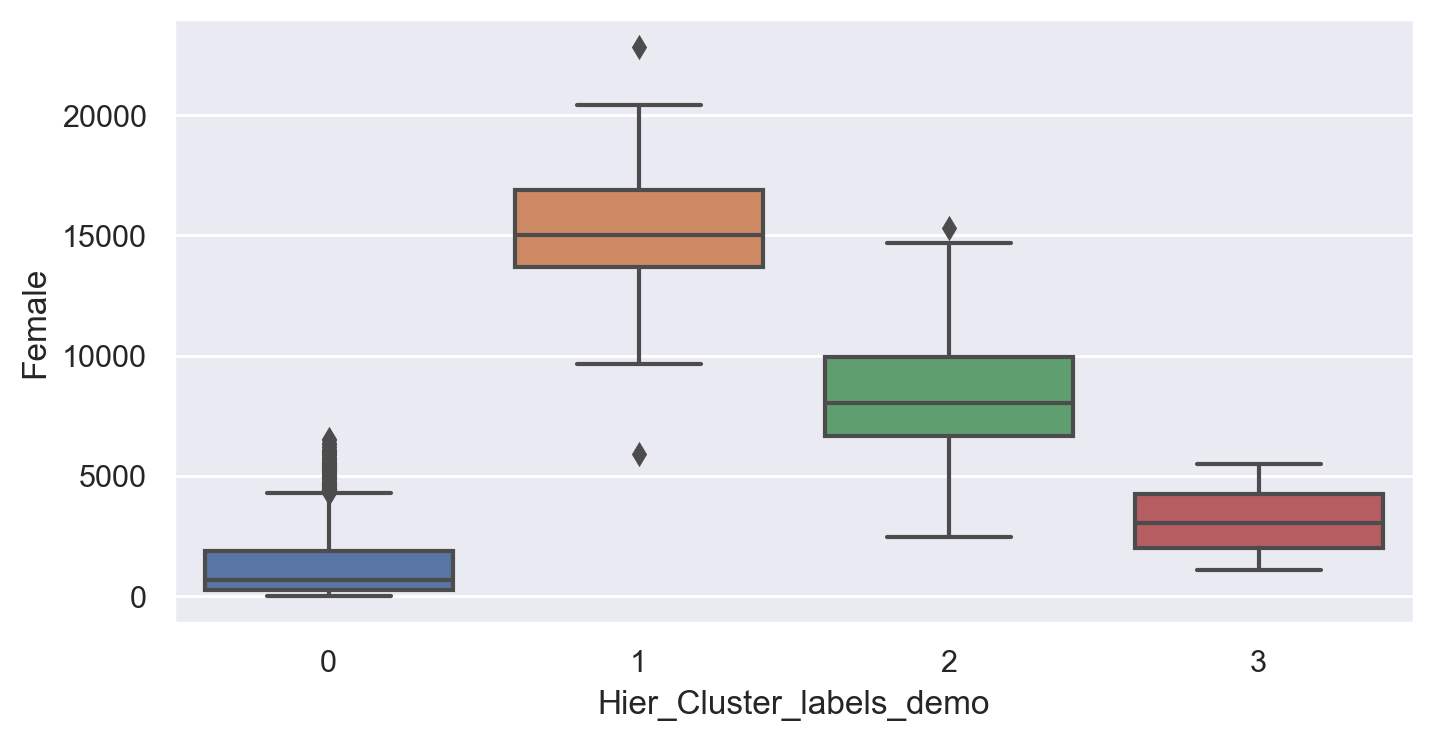

In [56]:
#plotting the clusters against Female
plt.figure(figsize=(8,4),dpi=200)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Female', data=demo_outliers_removed)

<AxesSubplot:xlabel='Hier_Cluster_labels_demo', ylabel='Single'>

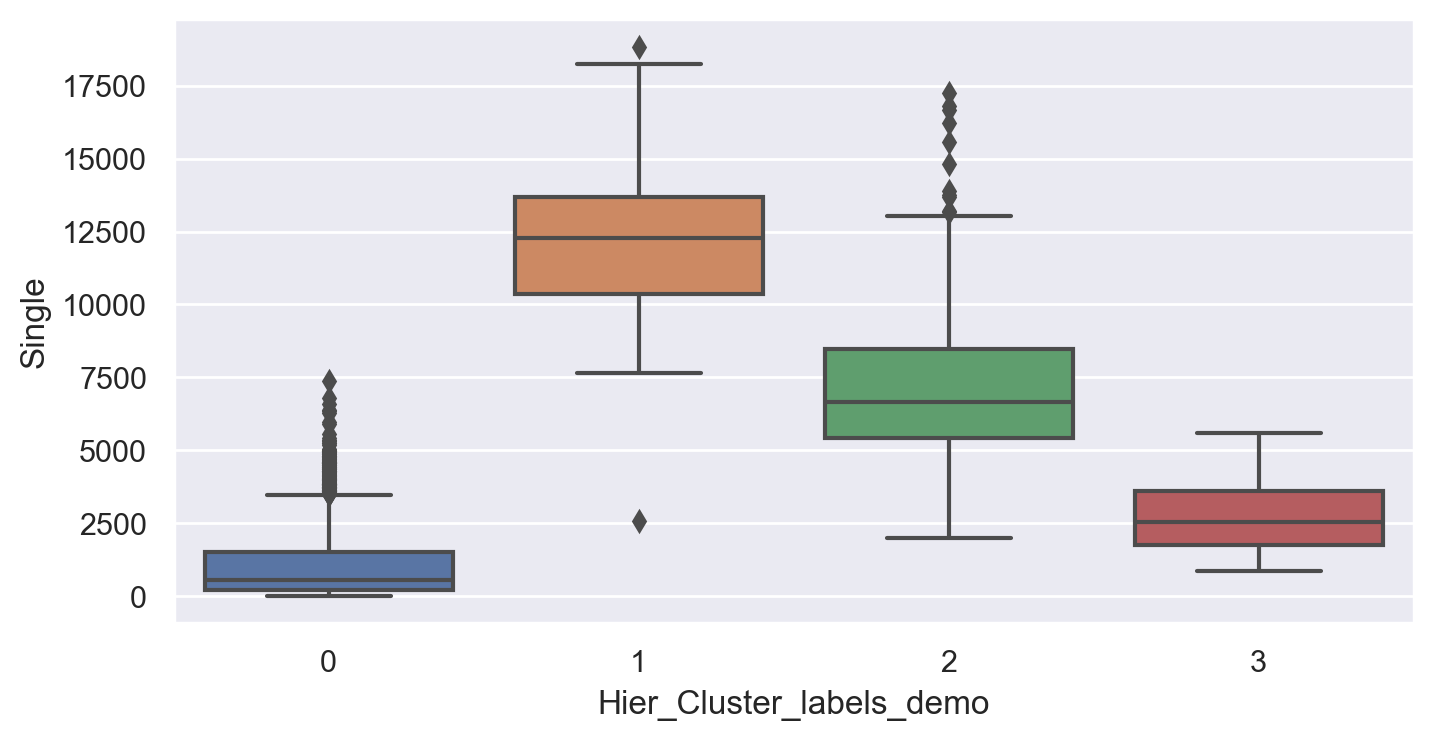

In [57]:
#plotting the clusters against Single
plt.figure(figsize=(8,4),dpi=200)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Single', data=demo_outliers_removed)

<AxesSubplot:xlabel='Hier_Cluster_labels_demo', ylabel='Female'>

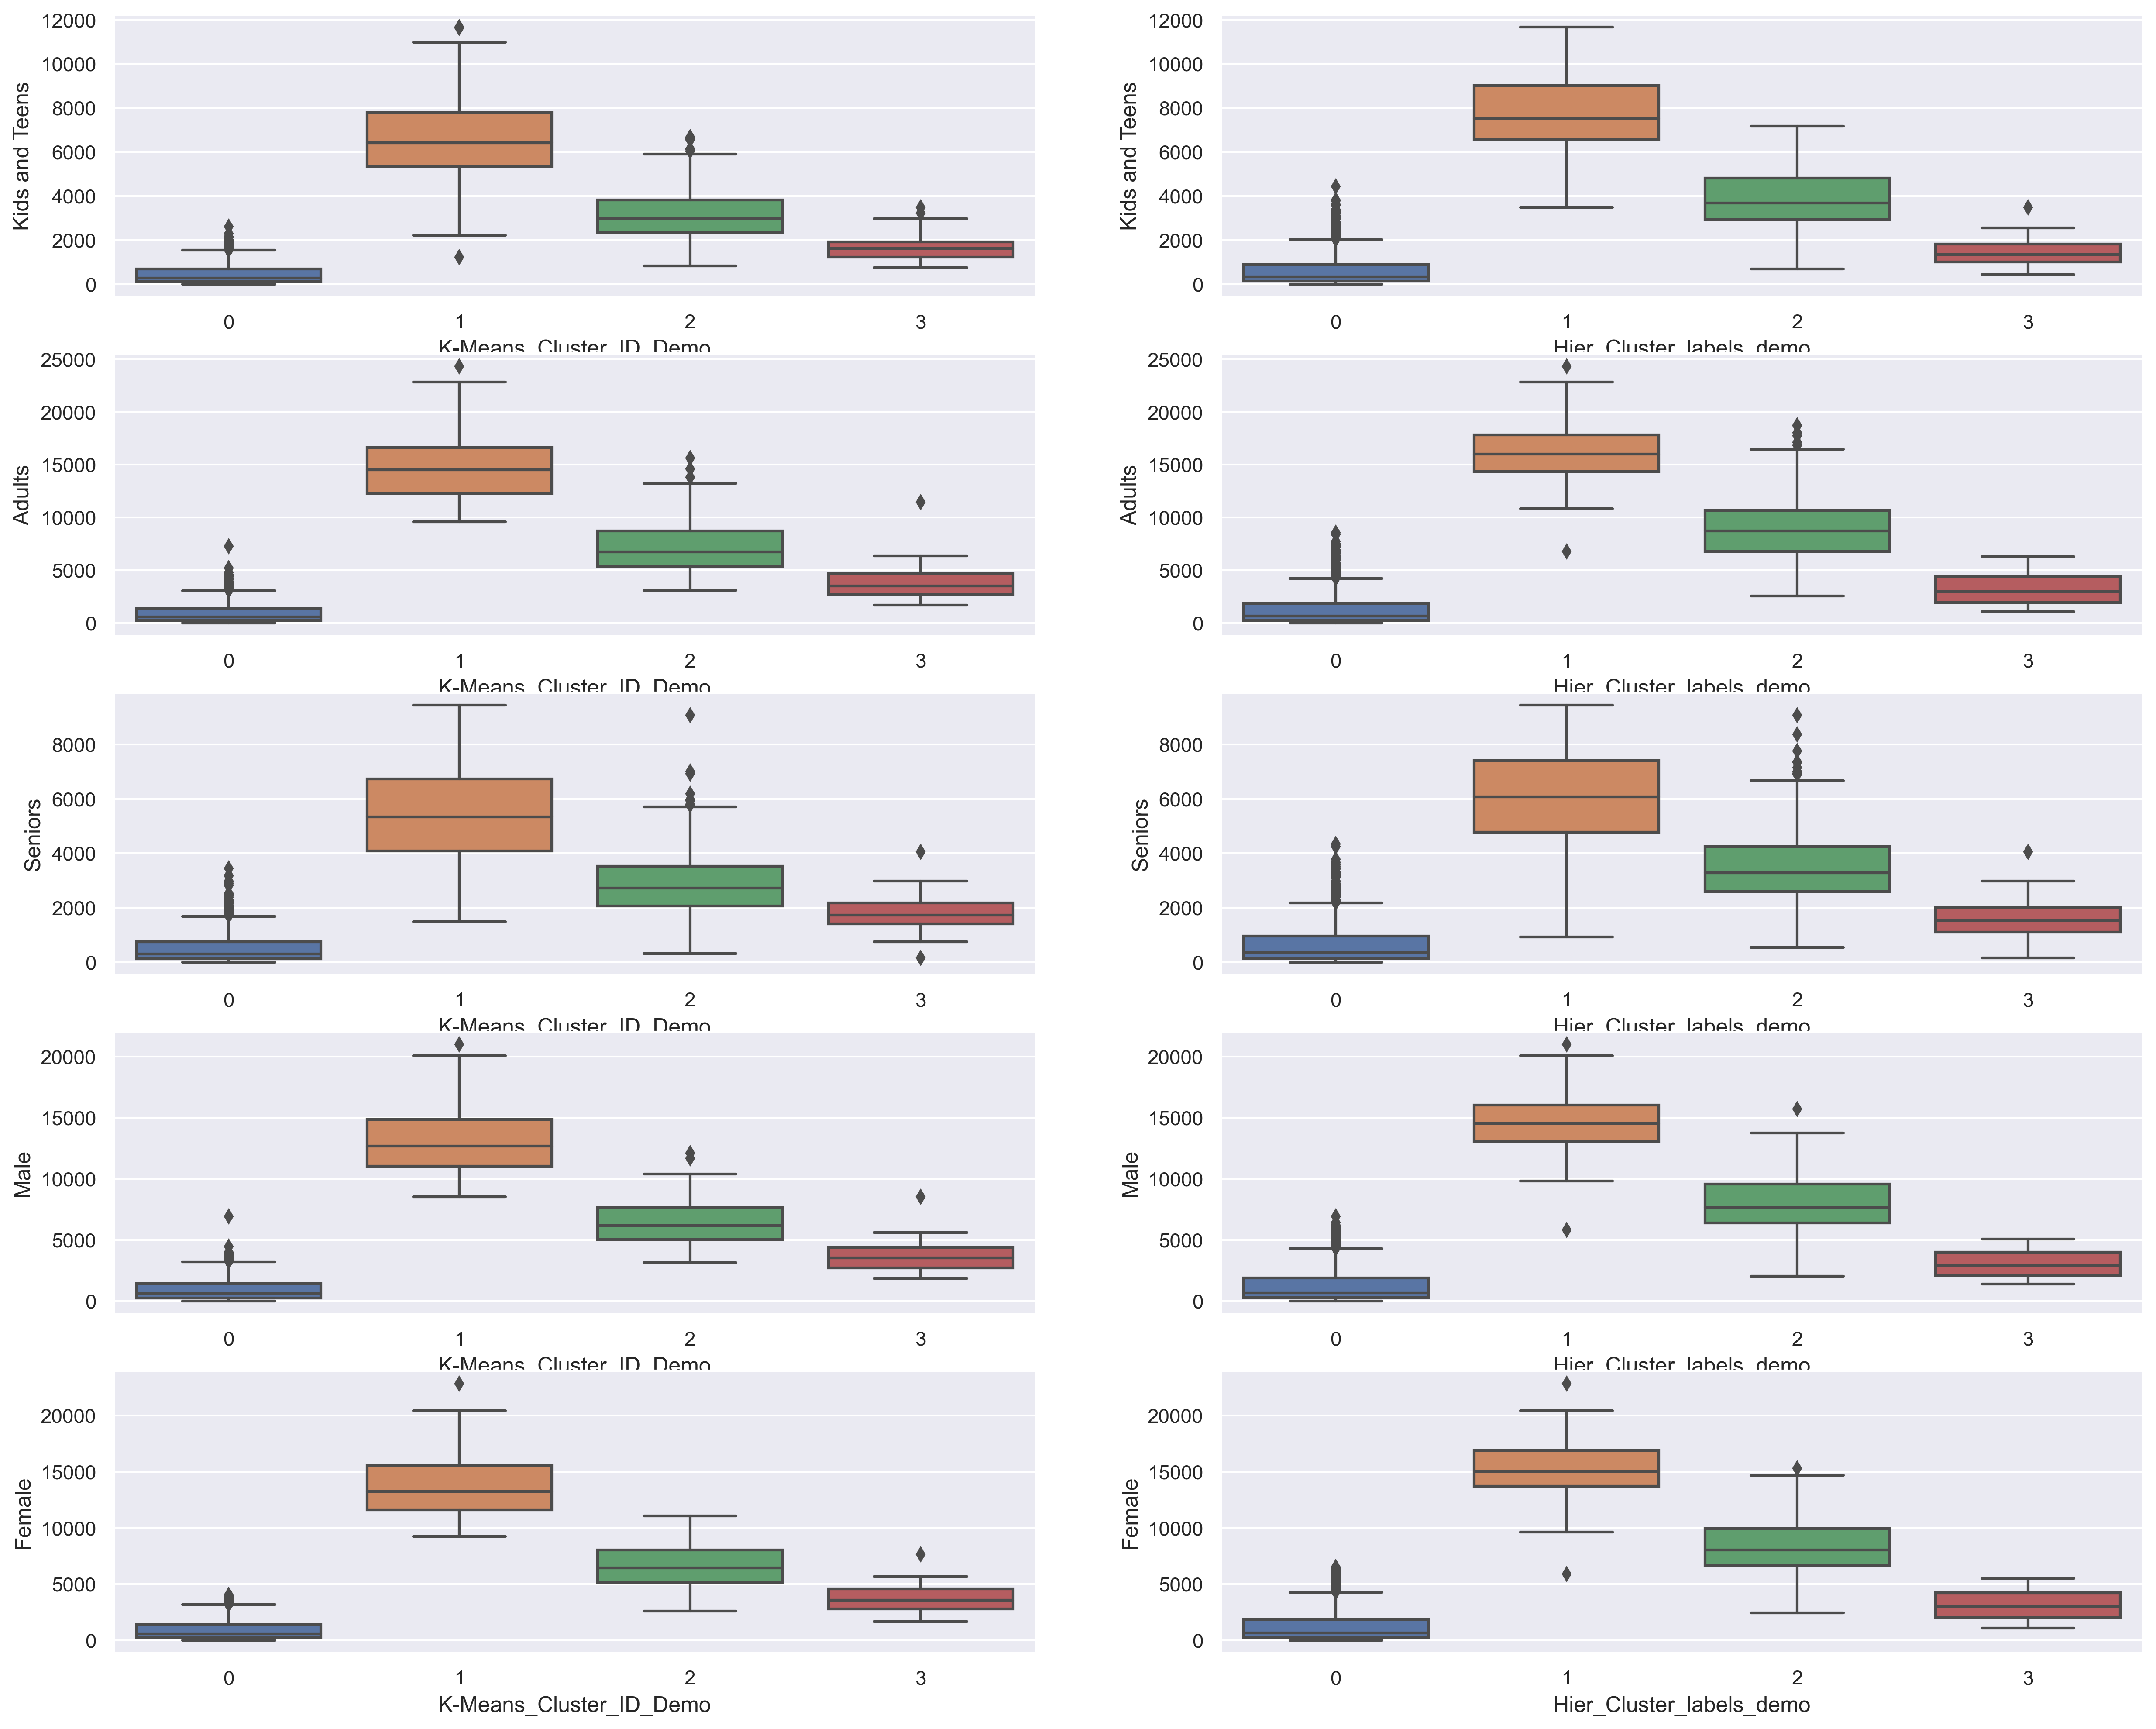

In [58]:
# plotting sub-plots to analyse the results: Age and Gender

plt.figure(figsize=(20,20), dpi=300)


plt.subplot(6,2,1)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Kids and Teens', data=demo_outliers_removed)

plt.subplot(6,2,2)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Kids and Teens', data=demo_outliers_removed)

plt.subplot(6,2,3)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y= 'Adults', data=demo_outliers_removed)

plt.subplot(6,2,4)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Adults', data=demo_outliers_removed)

plt.subplot(6,2,5)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Seniors', data=demo_outliers_removed)

plt.subplot(6,2,6)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Seniors', data=demo_outliers_removed)

plt.subplot(6,2,7)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Male', data=demo_outliers_removed)

plt.subplot(6,2,8)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Male', data=demo_outliers_removed)

plt.subplot(6,2,9)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Female', data=demo_outliers_removed)

plt.subplot(6,2,10)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Female', data=demo_outliers_removed)


<AxesSubplot:xlabel='Hier_Cluster_labels_demo', ylabel='Judaism'>

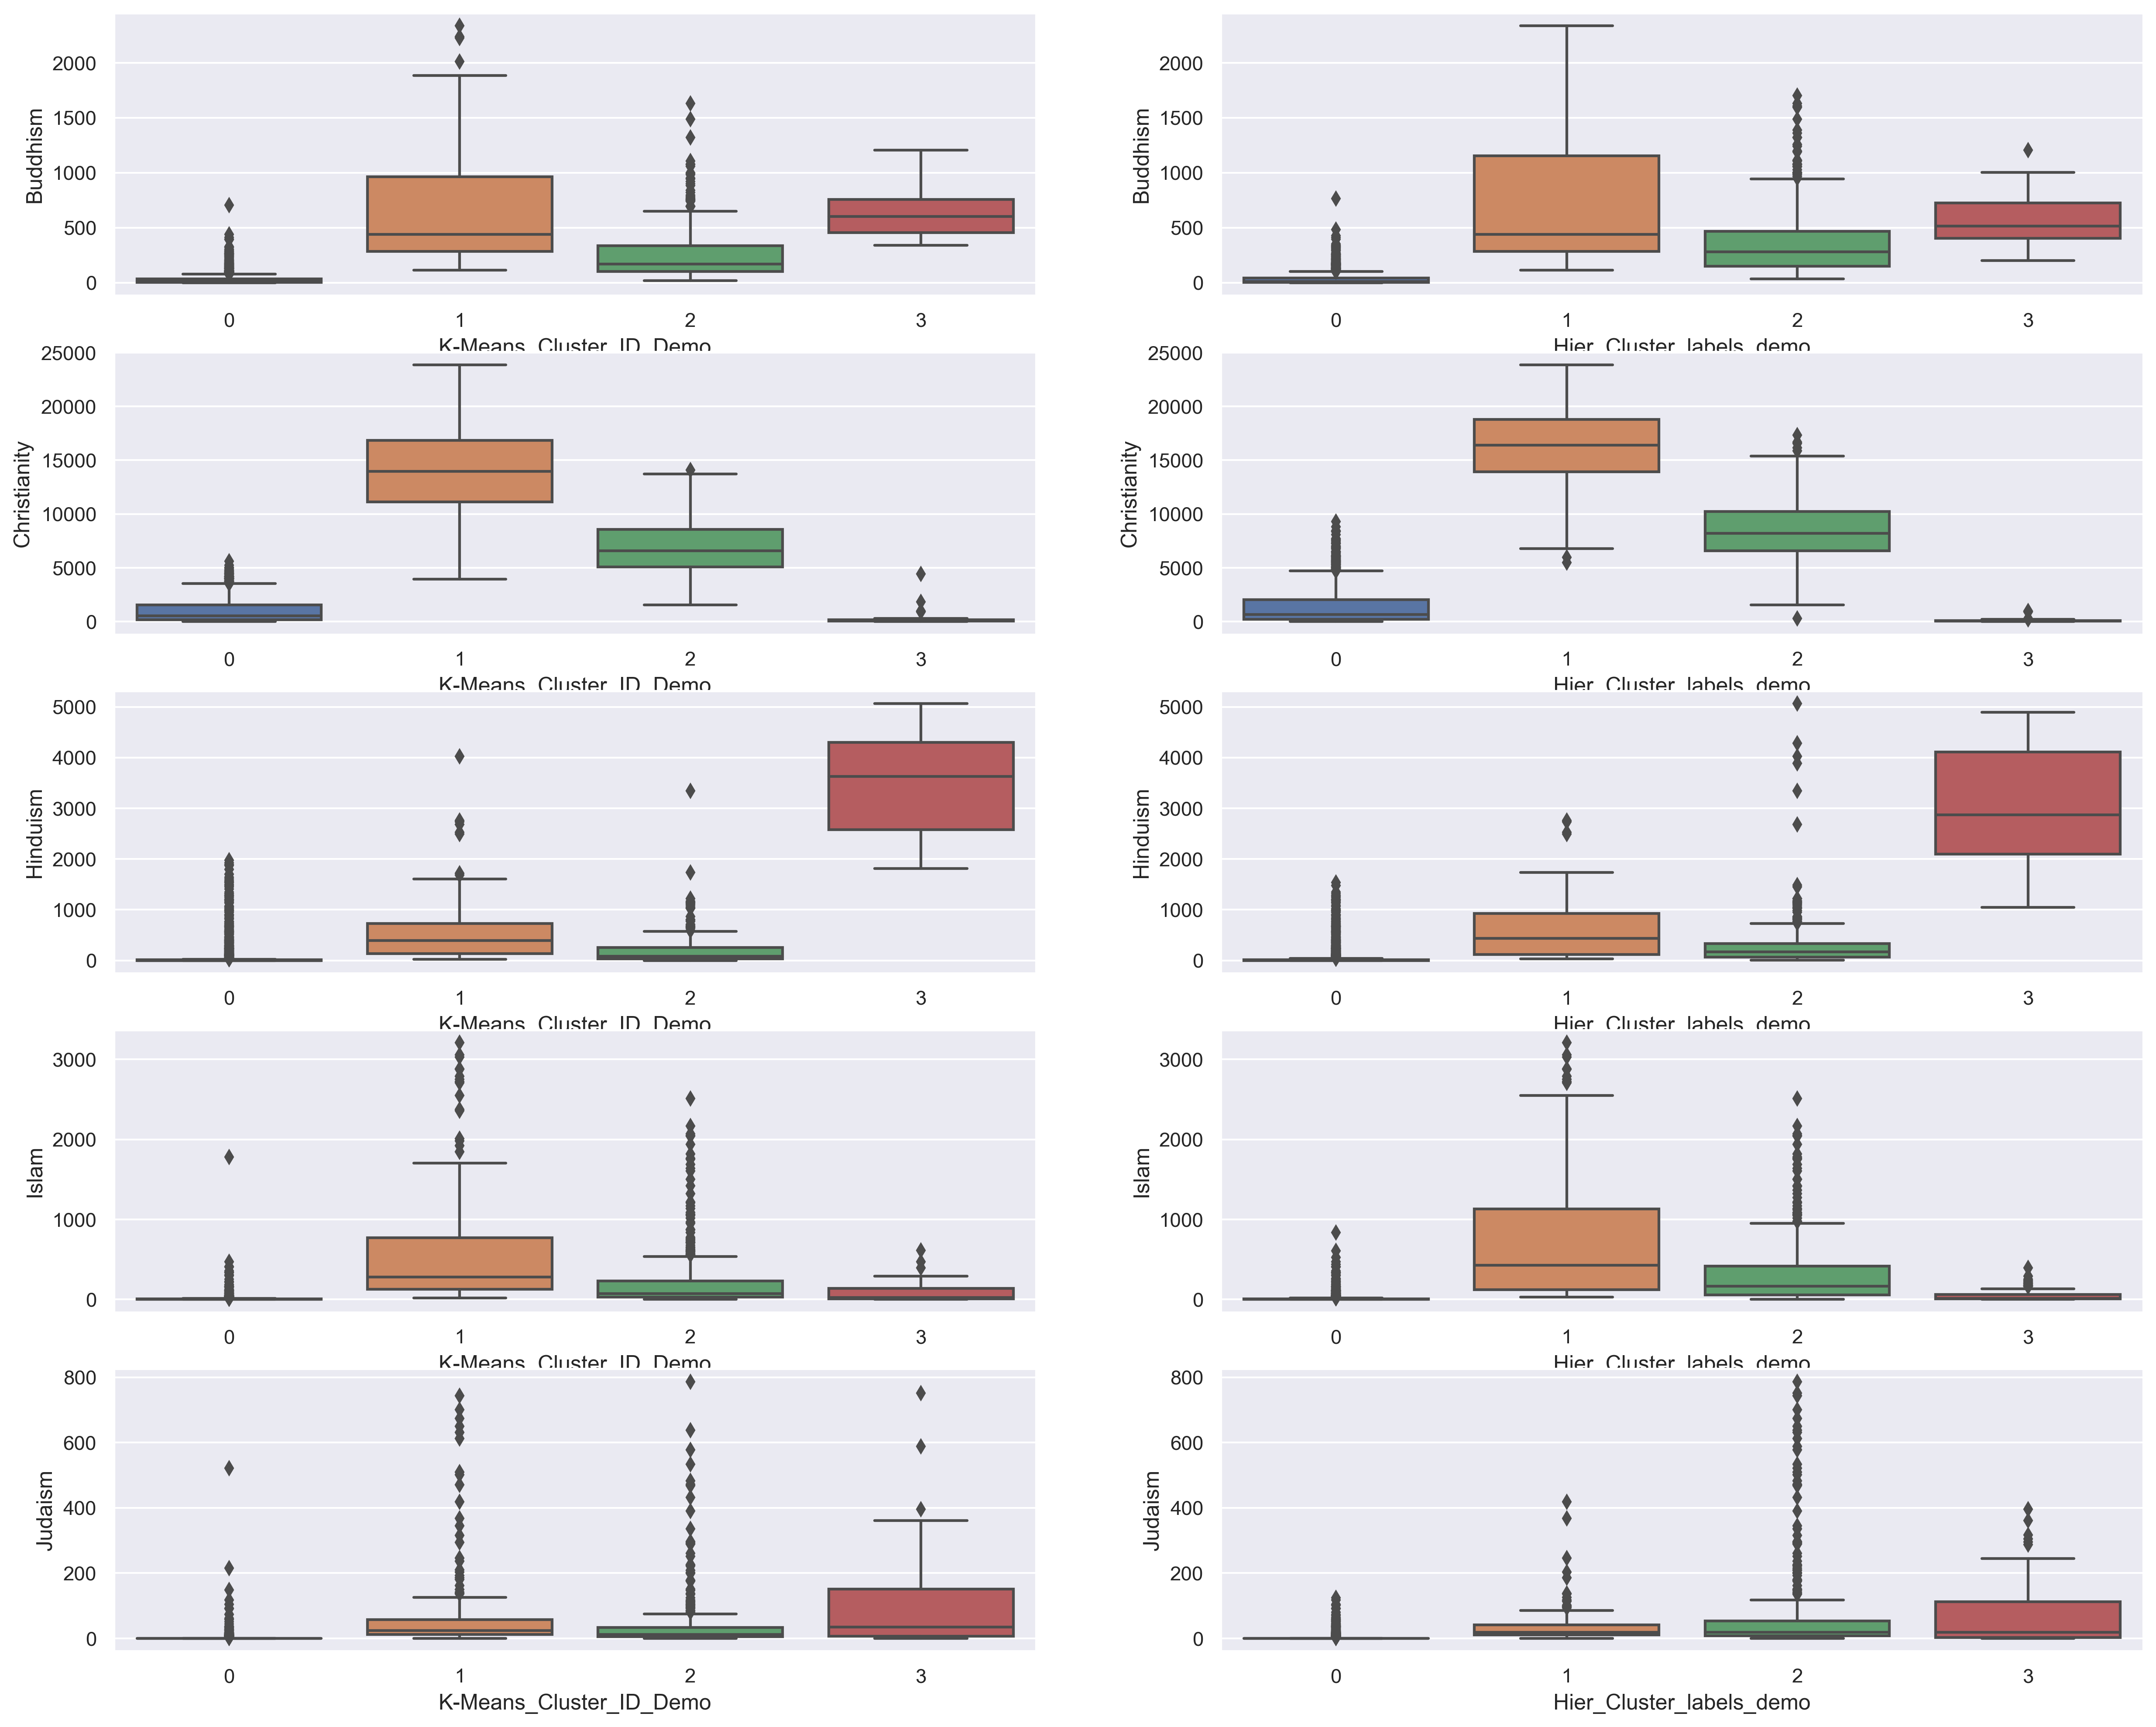

In [59]:
# plotting sub-plots to analyse the results: Religious Affiliation pt. 1


plt.figure(figsize=(20,20), dpi=300)


plt.subplot(6,2,1)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Buddhism', data=demo_outliers_removed)

plt.subplot(6,2,2)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Buddhism', data=demo_outliers_removed)

plt.subplot(6,2,3)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Christianity', data=demo_outliers_removed)

plt.subplot(6,2,4)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Christianity', data=demo_outliers_removed)

plt.subplot(6,2,5)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Hinduism', data=demo_outliers_removed)

plt.subplot(6,2,6)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Hinduism', data=demo_outliers_removed)

plt.subplot(6,2,7)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Islam', data=demo_outliers_removed)

plt.subplot(6,2,8)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Islam', data=demo_outliers_removed)

plt.subplot(6,2,9)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Judaism', data=demo_outliers_removed)

plt.subplot(6,2,10)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Judaism', data=demo_outliers_removed)



<AxesSubplot:xlabel='Hier_Cluster_labels_demo', ylabel='Not stated/described'>

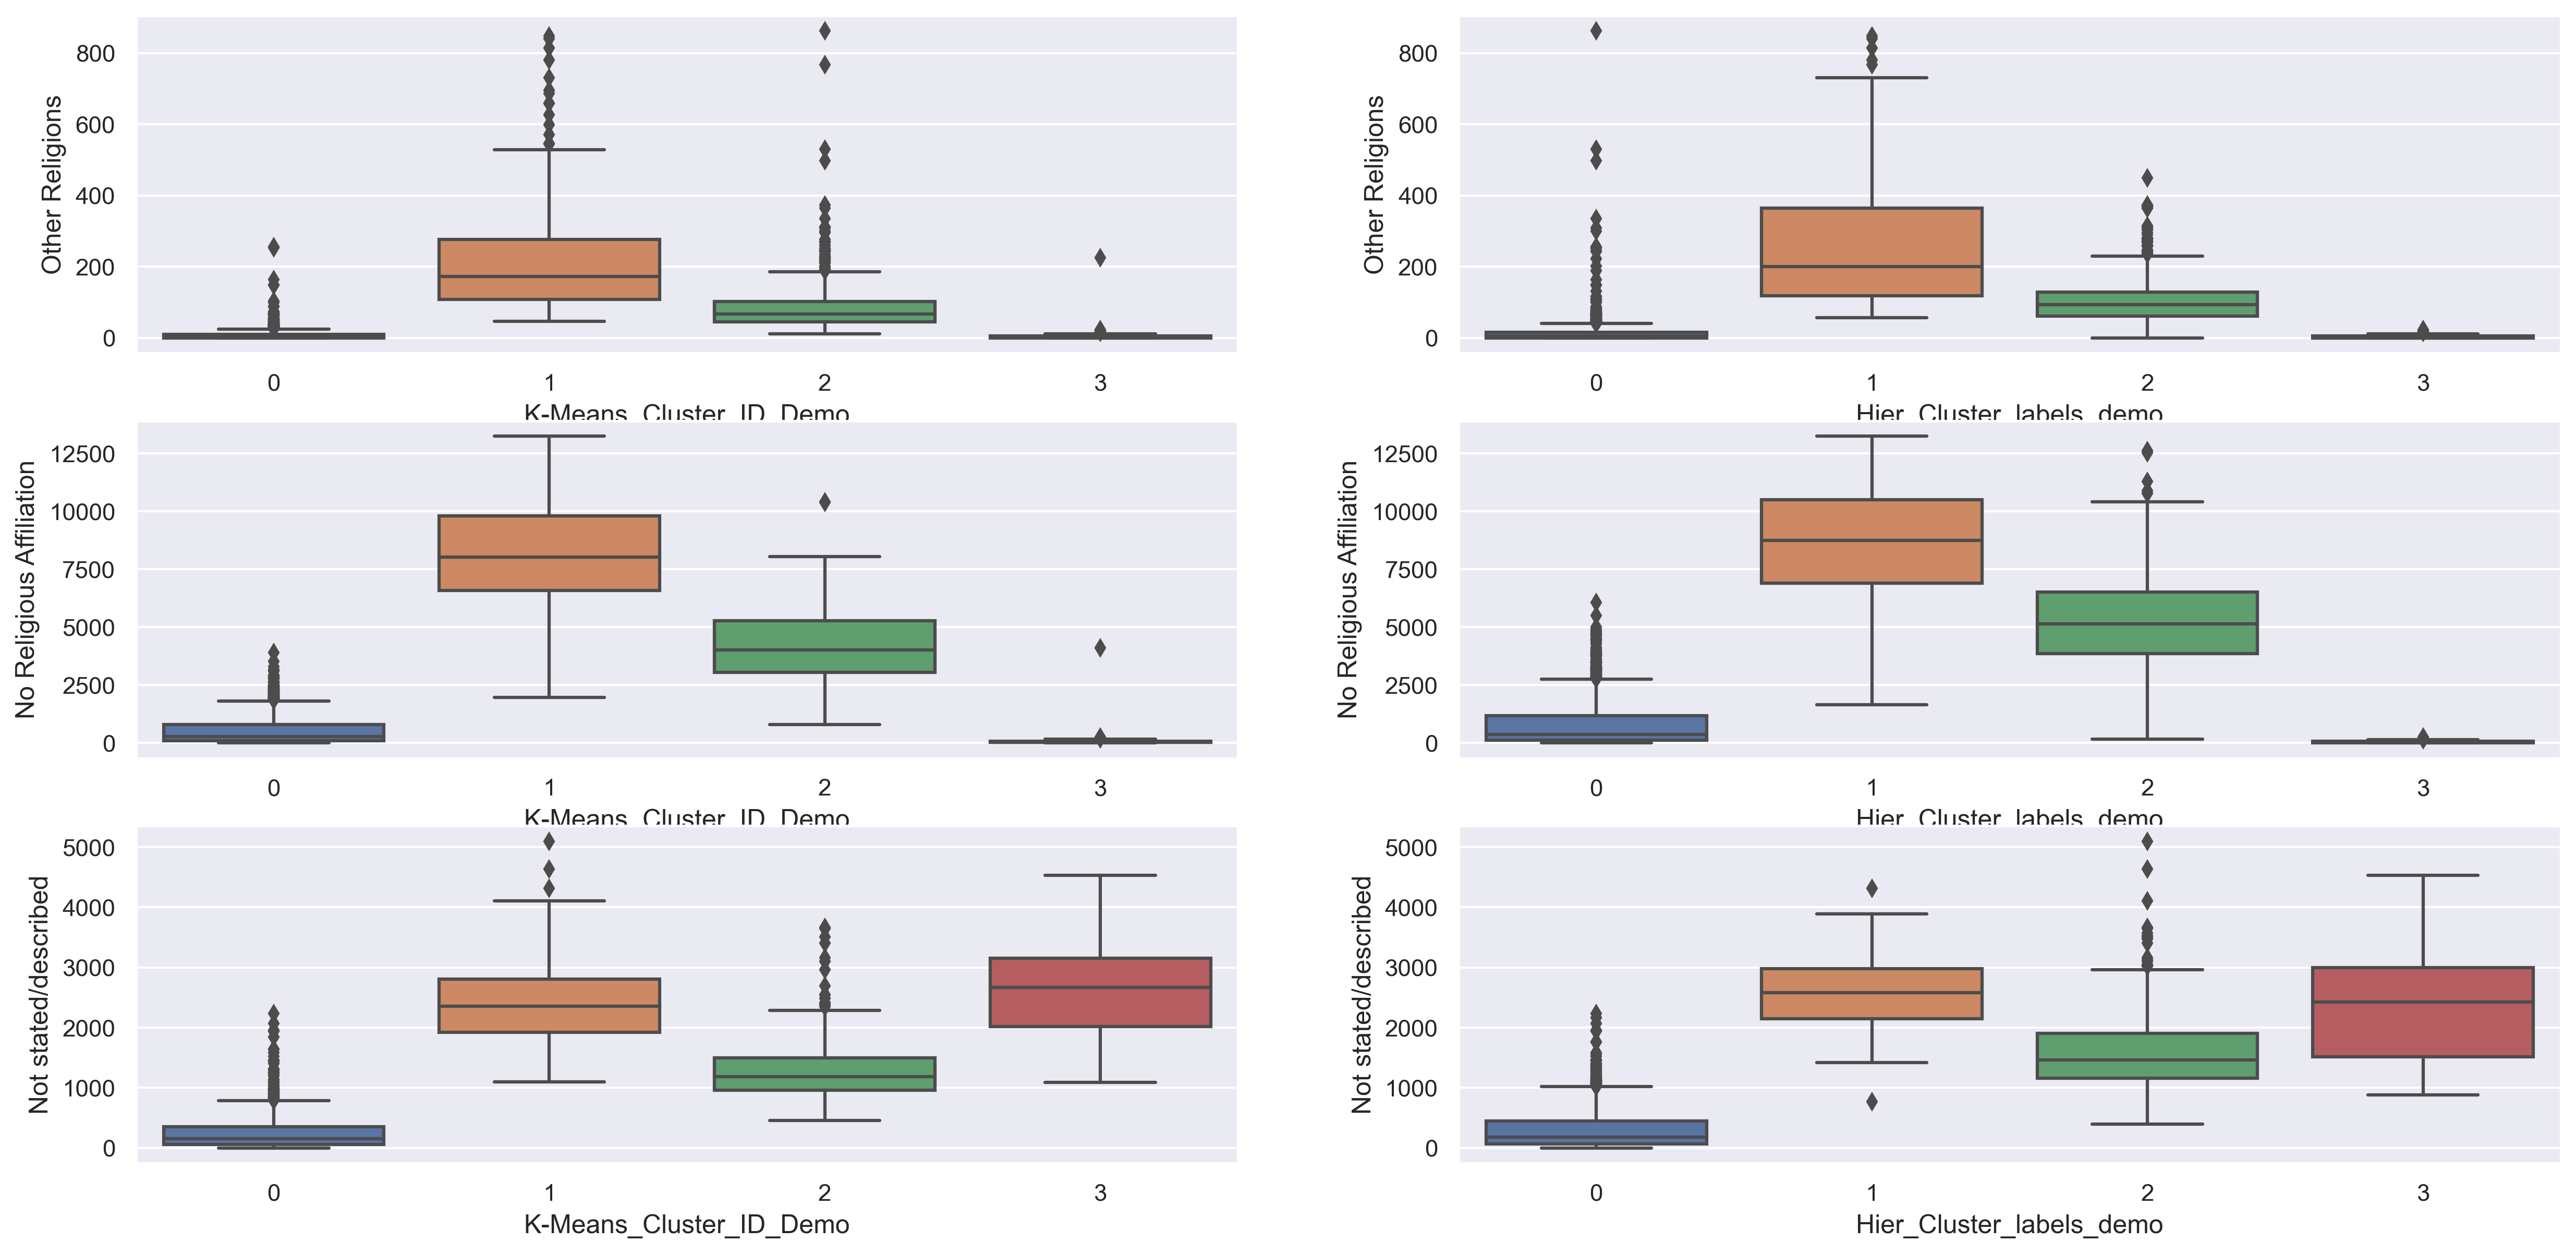

In [60]:
# plotting sub-plots to analyse the results: Religious Affiliation pt. 2

plt.figure(figsize=(20,20), dpi=300)

plt.subplot(6,2,1)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Other Religions', data=demo_outliers_removed)

plt.subplot(6,2,2)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Other Religions', data=demo_outliers_removed)

plt.subplot(6,2,3)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='No Religious Affiliation', data=demo_outliers_removed)

plt.subplot(6,2,4)
sns.boxplot(x='Hier_Cluster_labels_demo', y='No Religious Affiliation', data=demo_outliers_removed)

plt.subplot(6,2,5)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Not stated/described', data=demo_outliers_removed)

plt.subplot(6,2,6)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Not stated/described', data=demo_outliers_removed)

<AxesSubplot:xlabel='Hier_Cluster_labels_demo', ylabel='Not applicable'>

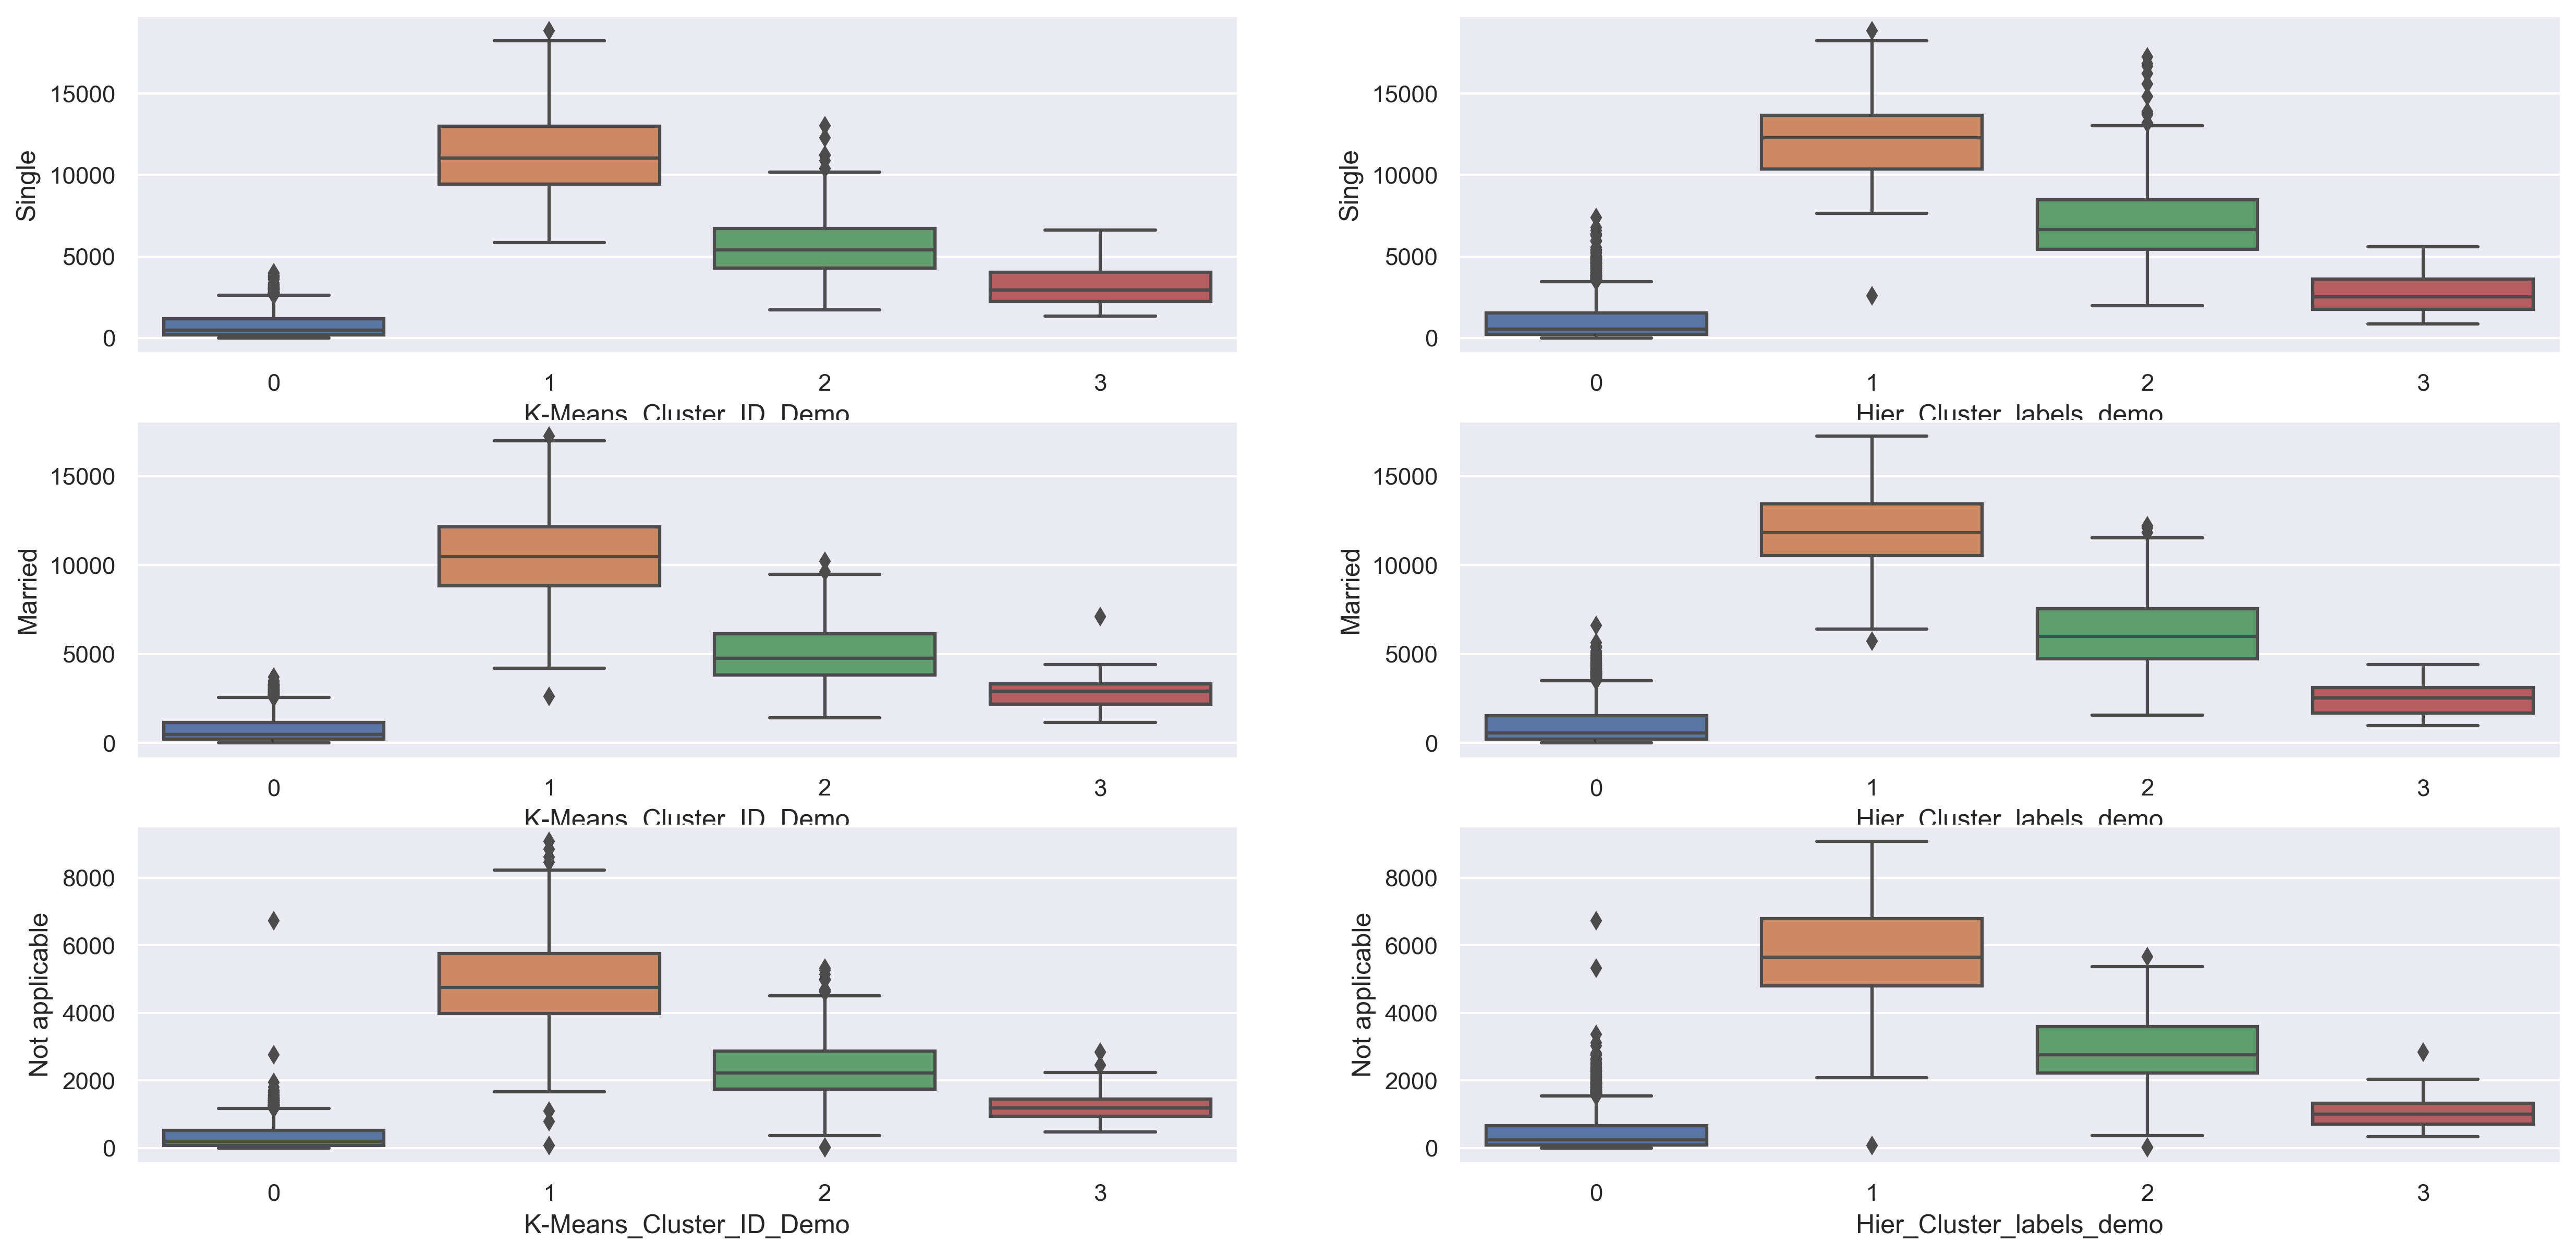

In [61]:

# plotting sub-plots to analyse the results: Marital Status


plt.figure(figsize=(20,20), dpi=300)

plt.subplot(6,2,1)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Single', data=demo_outliers_removed)

plt.subplot(6,2,2)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Single', data=demo_outliers_removed)

plt.subplot(6,2,3)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Married', data=demo_outliers_removed)

plt.subplot(6,2,4)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Married', data=demo_outliers_removed)

plt.subplot(6,2,5)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='Not applicable', data=demo_outliers_removed)

plt.subplot(6,2,6)
sns.boxplot(x='Hier_Cluster_labels_demo', y='Not applicable', data=demo_outliers_removed)

Creating a dataframe with all the Prinicpal components and Cluster labels/IDs. 

In [62]:
X_pca_demo_final_df = pd.DataFrame(X_pca_demo_final, columns = ['PC1', 'PC2','PC3','PC4'])

In [63]:
X_pca_demo_final_df.head()

,PC1,PC2,PC3,PC4
0,-0.184465,0.494422,0.099058,-0.152988
1,11.460154,1.341294,1.326850,-0.835358
2,5.062786,0.005140,0.400656,-0.469947
3,5.029888,0.072510,0.021797,-0.568842
4,-2.308431,-0.078005,0.197759,0.130689


In [64]:
X_pca_demo_final_df['K-Means_Cluster_ID_Demo'] = kmeans_demo.labels_
X_pca_demo_final_df['Hier_Cluster_Labels_Demo'] = w_cluster_labels_demo

In [65]:
X_pca_demo_final_df.head()

,PC1,PC2,PC3,PC4,K-Means_Cluster_ID_Demo,Hier_Cluster_Labels_Demo
0,-0.184465,0.494422,0.099058,-0.152988,0,0
1,11.460154,1.341294,1.326850,-0.835358,1,1
2,5.062786,0.005140,0.400656,-0.469947,2,2
3,5.029888,0.072510,0.021797,-0.568842,2,2
4,-2.308431,-0.078005,0.197759,0.130689,0,0


Plotting PC agants Clusters

<AxesSubplot:xlabel='K-Means_Cluster_ID_Demo', ylabel='PC1'>

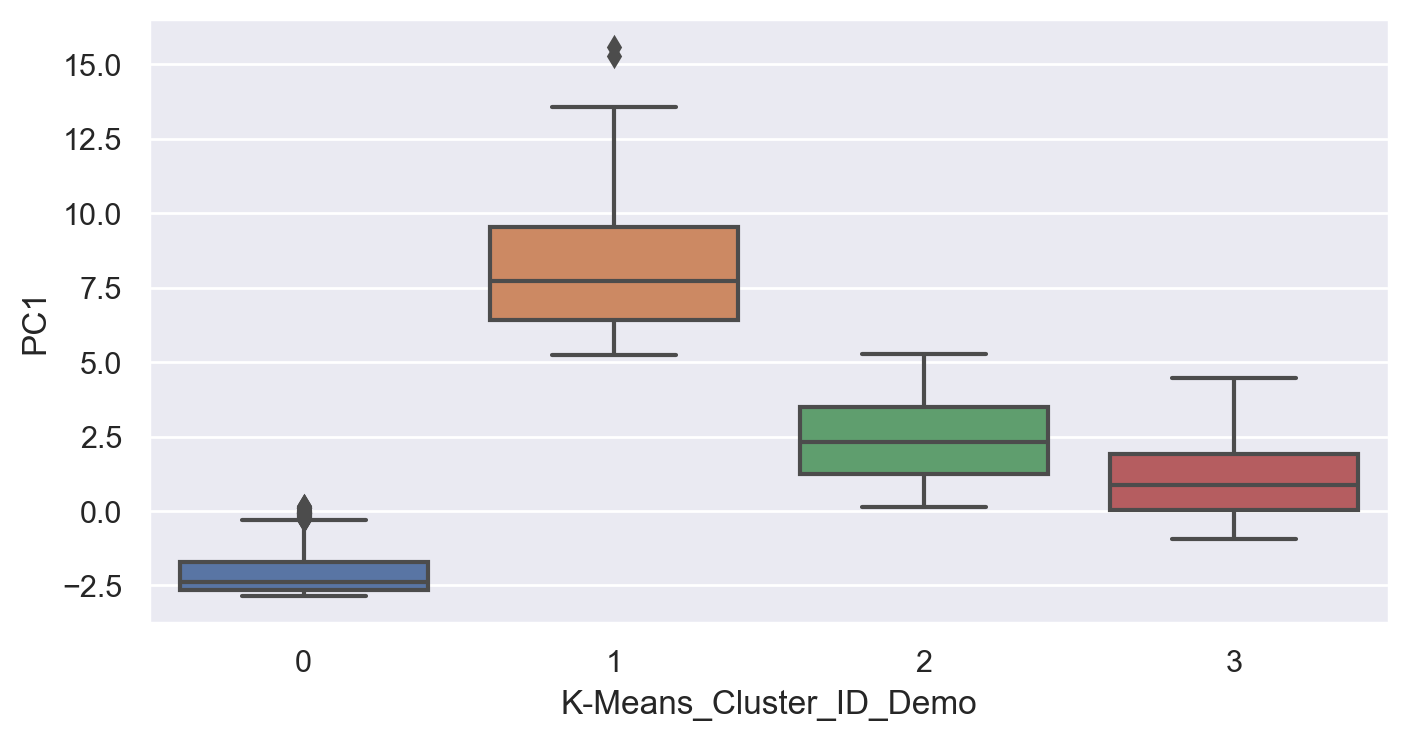

In [66]:
plt.figure(figsize=(8,4),dpi=200)
sns.boxplot(x='K-Means_Cluster_ID_Demo', y='PC1', data= X_pca_demo_final_df)

### Scatterplots of first two PCs 

To observe the cluster distribution

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

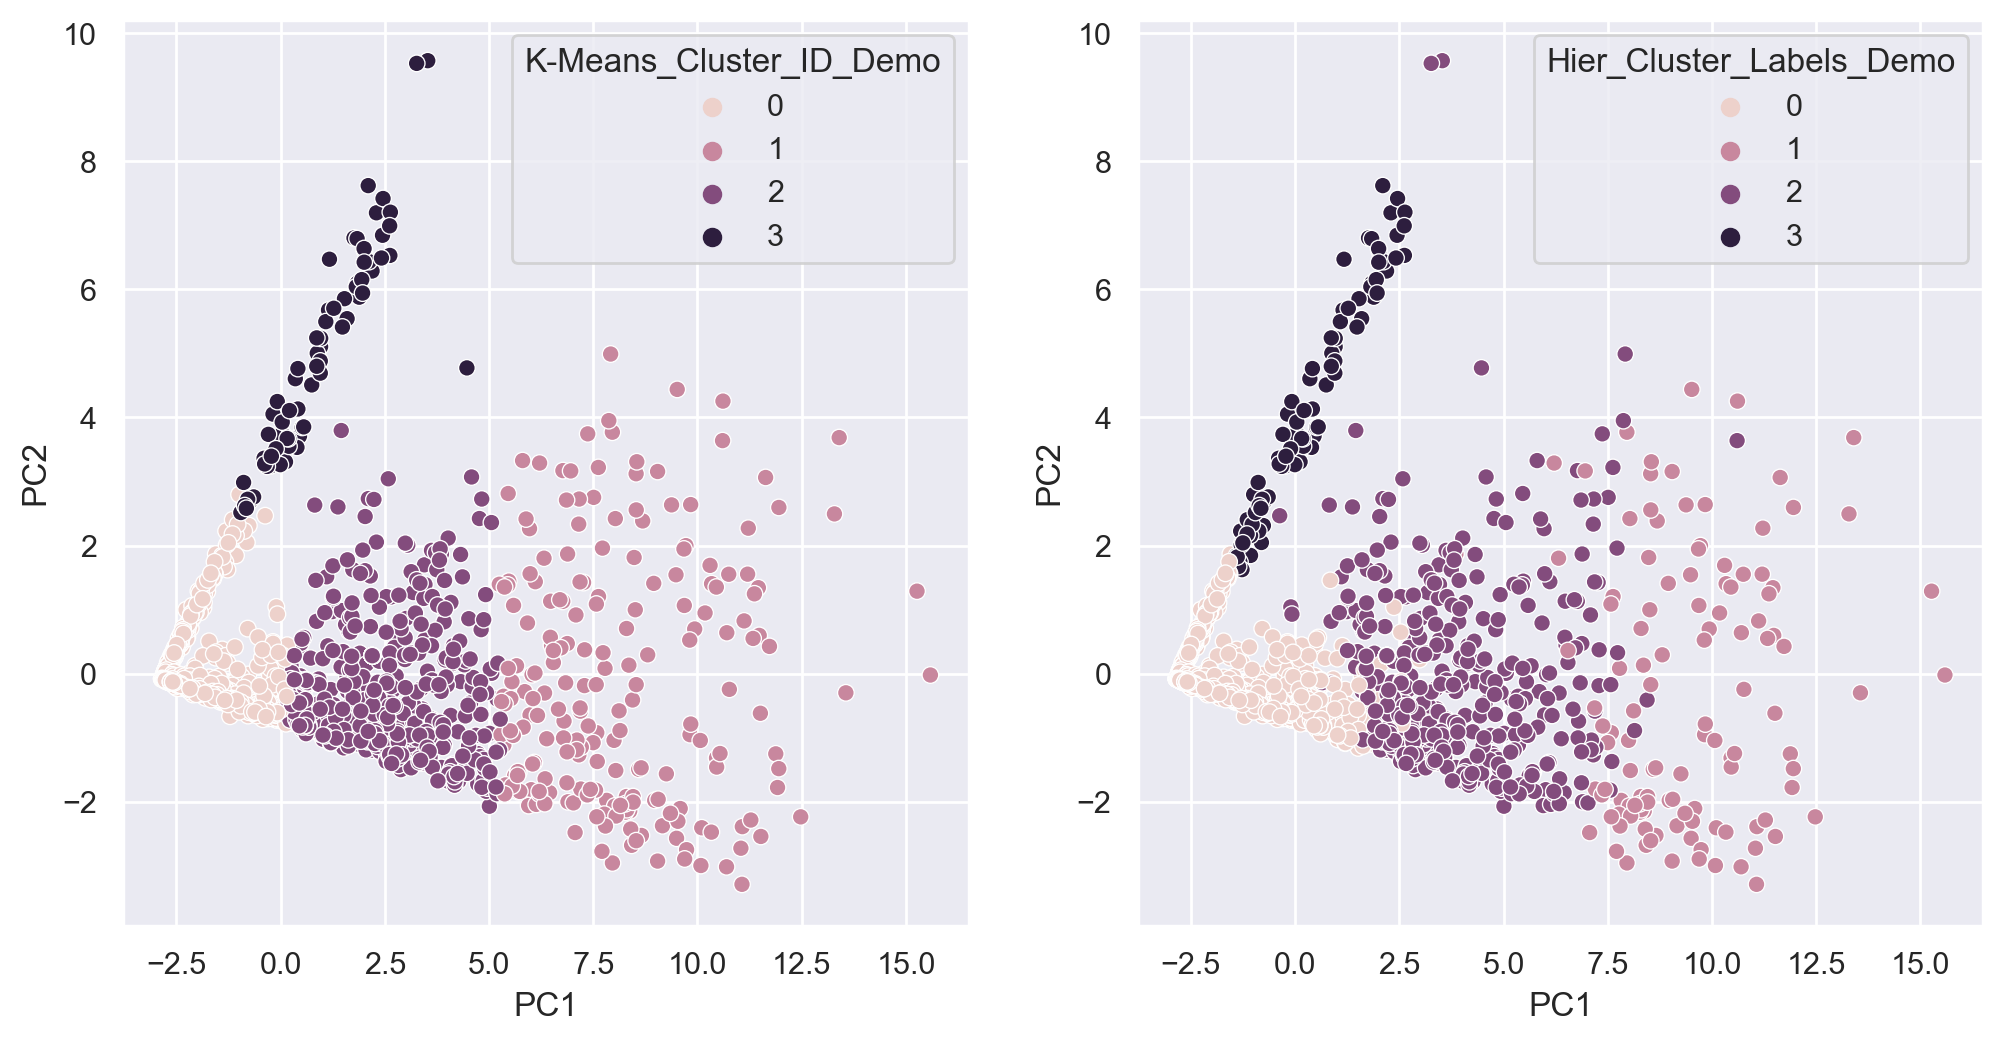

In [67]:
# scatter plot using the first two principal components to observe the cluster distribution

plt.figure(figsize=(12,6),dpi=200)

plt.subplot(1,2,1)
sns.scatterplot(x='PC1',y='PC2',data=X_pca_demo_final_df,hue='K-Means_Cluster_ID_Demo')

plt.subplot(1,2,2)
sns.scatterplot(x='PC1',y='PC2',data=X_pca_demo_final_df,hue='Hier_Cluster_Labels_Demo')

### Correlation 

In [68]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings_demo= pca_demo.components_
num_pc_demo = pca_demo.n_features_
pc_list_demo = ["PC"+str(i) for i in list(range(1, num_pc_demo+1))]
loadings_demo_df = pd.DataFrame.from_dict(dict(zip(pc_list_demo, loadings_demo)))
loadings_demo_df['variable'] = X_demo.columns.values
loadings_demo_df = loadings_demo_df.set_index('variable')
loadings_demo_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
variable,,,,,,,,,,,,,,,,
Kids and Teens,0.283785,-0.112341,0.004957,-0.083920,0.089215,0.196672,-0.131991,-0.333017,0.107388,0.115806,-0.067569,0.766730,0.024952,-0.076309,0.177210,0.263789
Adults,0.289498,-0.025314,-0.024229,0.030859,-0.066745,-0.134609,0.167127,-0.164640,-0.108909,-0.376794,-0.142212,-0.303003,0.179578,0.293601,0.343237,0.578159
Seniors,0.270493,-0.115637,-0.136612,-0.114453,-0.094571,0.141443,-0.242114,0.754916,-0.045965,0.291876,0.183791,0.003445,0.169014,0.072207,0.135817,0.225633
Male,0.291566,-0.065274,-0.035210,-0.031141,-0.036428,0.003170,0.039311,-0.026753,0.017323,-0.152533,-0.142937,-0.057639,0.629726,-0.355387,0.273262,-0.509975
Female,0.291454,-0.069888,-0.048186,-0.026919,-0.033510,0.008306,-0.024168,0.001542,-0.100948,-0.082674,0.026657,0.107541,-0.321611,0.651535,0.250914,-0.533998
Buddhism,0.210453,0.419301,0.210619,0.041989,-0.287941,-0.586319,-0.448526,-0.050194,0.300975,0.032426,0.086475,0.042708,0.020719,0.011587,-0.043525,0.000178
Christianity,0.277451,-0.219006,-0.016510,-0.021357,0.017835,0.201148,-0.188214,0.041468,0.188177,-0.490280,0.030779,0.014905,0.126480,0.137394,-0.696111,0.002552
Hinduism,0.075995,0.683567,-0.078054,-0.482986,0.173365,0.222349,-0.064469,-0.043775,-0.413926,-0.111454,0.057831,0.014188,0.065449,0.006317,-0.101980,0.000396
Islam,0.166397,0.221130,0.615698,0.374785,-0.374604,0.448821,0.177213,0.044374,-0.123460,0.090800,-0.049956,-0.002282,0.007321,0.009895,-0.050828,0.000133


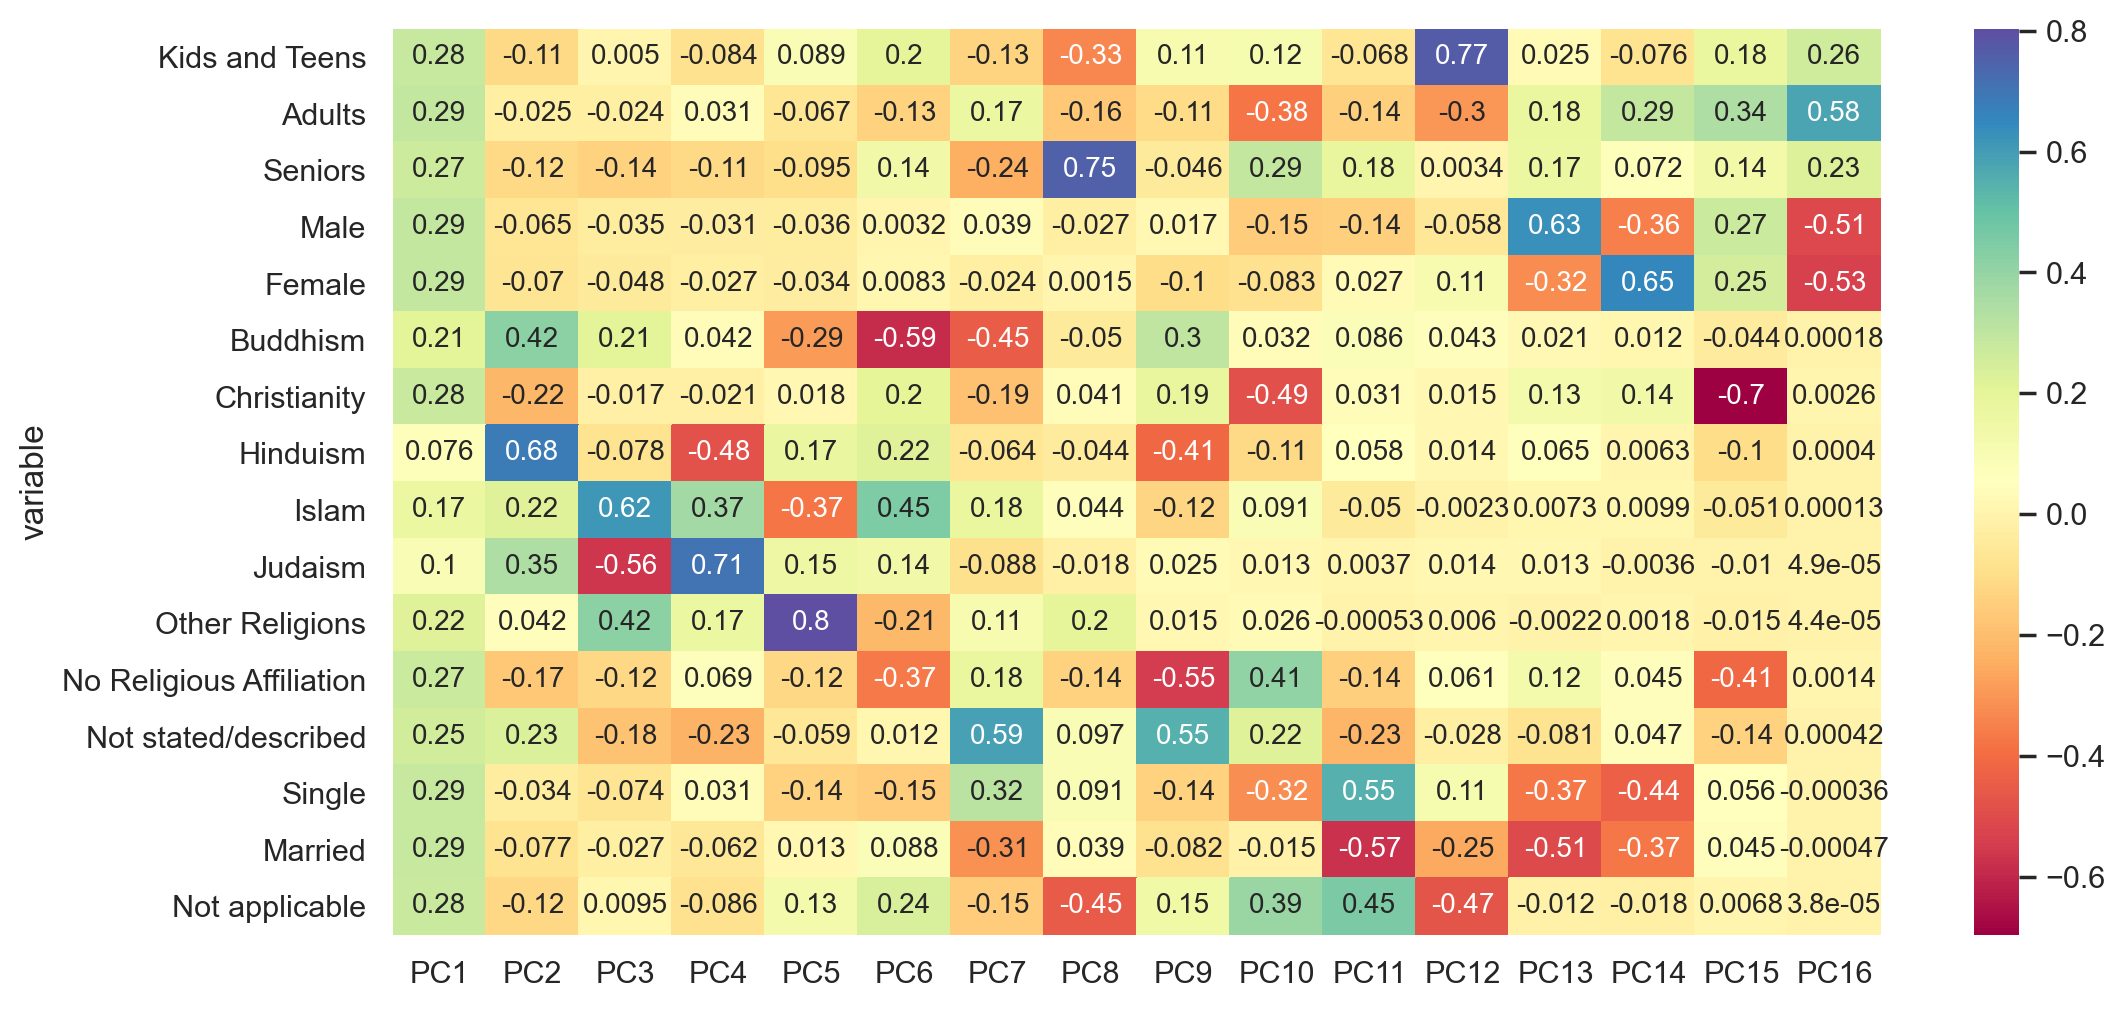

In [69]:
# positive and negative values in component loadings reflects the positive and negative 
# correlation of the variables with the PCs. Except A and B, all other variables have 
# positive projection on first PC.

# get correlation matrix plot for loadings

plt.figure(figsize=(12,6),dpi=200)
ax = sns.heatmap(loadings_demo_df, annot=True, cmap='Spectral')
plt.show()


# Finding similar postcodes: Demographics dataset


In [70]:
# update the index
demo_outliers_removed.set_index('Postcode', inplace=True)


# normalize the data into a new dataframe
from sklearn.preprocessing import MinMaxScaler
z_demo = demo_outliers_removed.values #returns a numpy array
min_max_scaler_demo = MinMaxScaler()
feature_mtx_demo = min_max_scaler_demo.fit_transform(z_demo)

df_normal_demo = pd.DataFrame(feature_mtx_demo, index=demo_outliers_removed.index, columns=demo_outliers_removed.columns)
df_normal_demo

,Kids and Teens,Adults,Seniors,Male,Female,Buddhism,Christianity,Hinduism,Islam,Judaism,Other Religions,No Religious Affiliation,Not stated/described,Single,Married,Not applicable,K-Means_Cluster_ID_Demo,Hier_Cluster_labels_demo
Postcode,,,,,,,,,,,,,,,,,,
800,0.056065,0.213822,0.065713,0.172842,0.124065,0.117295,0.093240,0.058277,0.029283,0.008895,0.056845,0.173093,0.241373,0.198811,0.126449,0.058998,0.000000,0.000000
810,0.736048,0.820260,0.505564,0.799009,0.723382,0.488870,0.632236,0.273805,0.261371,0.041931,0.423434,0.763752,0.846471,0.758985,0.710130,0.743203,0.333333,0.333333
812,0.453836,0.442978,0.296767,0.449705,0.412630,0.296233,0.393901,0.048795,0.099065,0.011436,0.157773,0.427601,0.471765,0.426236,0.392733,0.447881,0.666667,0.666667
820,0.334934,0.527134,0.288182,0.486045,0.404753,0.222175,0.361732,0.084156,0.080997,0.015248,0.174014,0.509394,0.528627,0.506025,0.397543,0.335828,0.666667,0.666667
828,0.033862,0.025530,0.021092,0.029863,0.025032,0.011130,0.020692,0.004149,0.004050,0.000000,0.023202,0.029427,0.047843,0.030153,0.022543,0.026747,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7331,0.036262,0.037083,0.049073,0.044008,0.037898,0.002568,0.045698,0.000000,0.001246,0.000000,0.009281,0.038406,0.034118,0.047672,0.032974,0.035993,0.000000,0.000000
7467,0.012002,0.015705,0.018654,0.016956,0.015273,0.000000,0.015037,0.000000,0.000000,0.000000,0.003480,0.021278,0.012157,0.017466,0.014951,0.013429,0.000000,0.000000
7468,0.014231,0.017102,0.018760,0.019289,0.015842,0.001712,0.015330,0.000000,0.000000,0.000000,0.006961,0.023165,0.016078,0.018740,0.015009,0.016401,0.000000,0.000000


In [71]:
# The following function takes in a postcode and returns the top 10 similar postcodes based on income dataset

def postrec_demo(postcode):
    
    try:
        #choose a postcode for comparison
        new_postcode = postcode
        new_postcode_df = list(df_normal_demo.loc[new_postcode])

        #get the absolute difference between the new postcode and all other postcode
        temp_df = df_normal_demo-new_postcode_df
        temp_df = temp_df.abs()
        recommendations = temp_df.sum(axis=1).sort_values().head(10)

        return recommendations

    except:
        print("Error: Postcode not found")

In [72]:
#Top 10 Postcodes similar to 800
postcode = 800
results = postrec_demo(postcode)
results

Postcode
800     0.000000
6004    0.319780
3002    0.335484
3051    0.479596
2130    0.503381
2061    0.539001
6720    0.549643
835     0.572429
6006    0.575996
3450    0.584809
dtype: float64

In [73]:
#Top 10 Postcodes similar to 2456
postcode = 7470
results = postrec_demo(postcode)
results

Postcode
7470    0.000000
7469    0.000000
6211    0.021224
2490    0.021995
3658    0.022770
7467    0.026289
2623    0.026466
3268    0.027460
6337    0.028040
7468    0.028256
dtype: float64